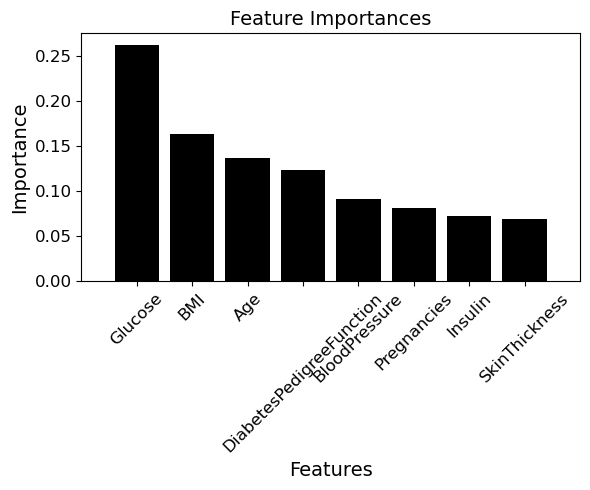

<Figure size 600x500 with 0 Axes>

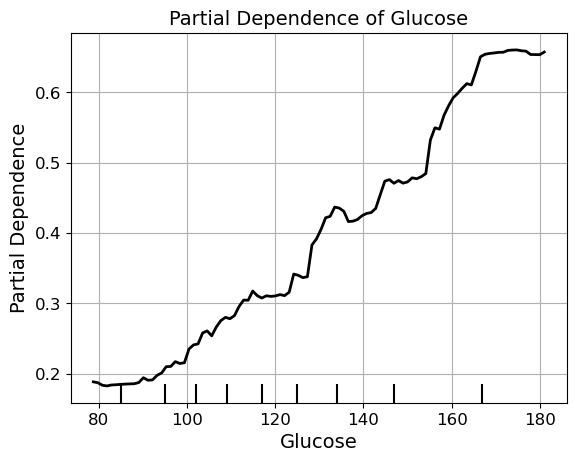

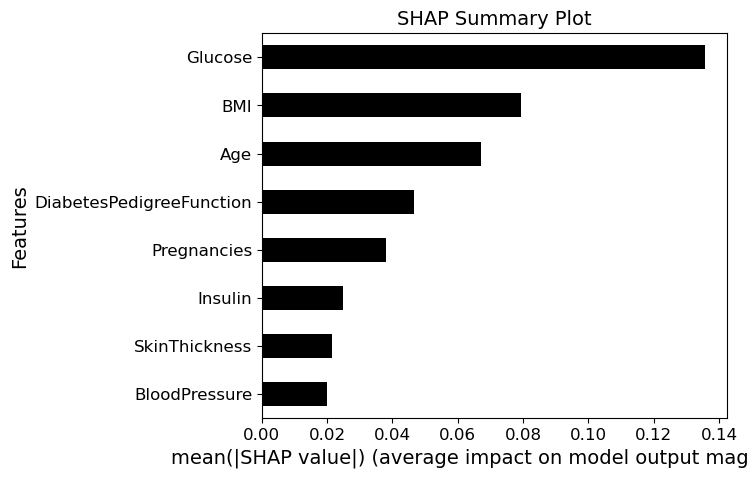

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


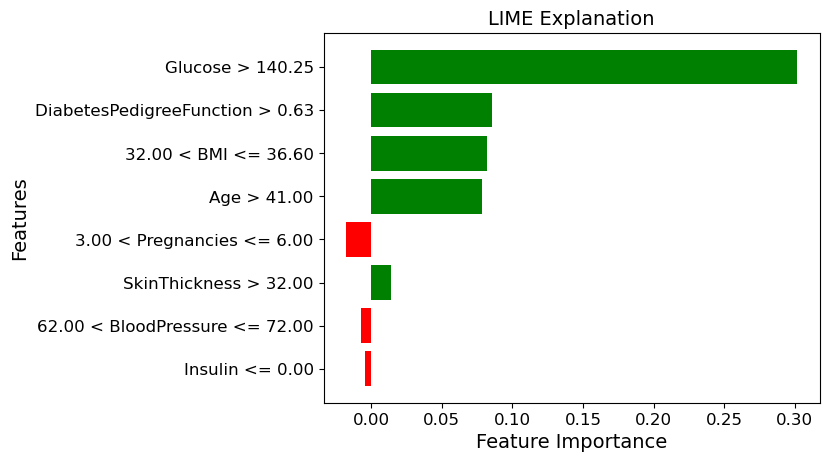

<Figure size 600x500 with 0 Axes>

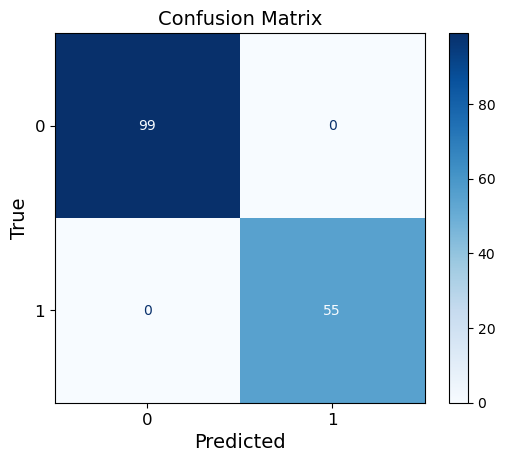

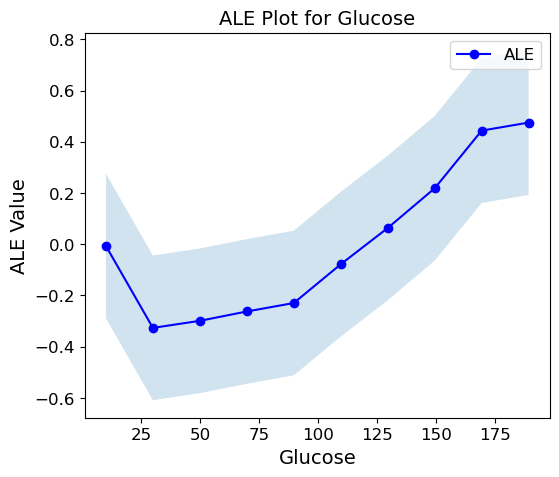

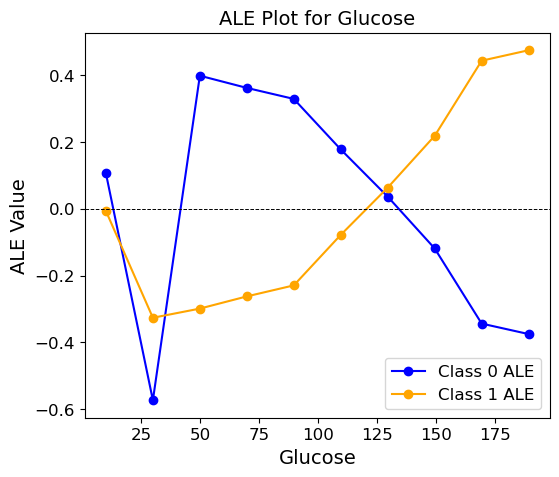

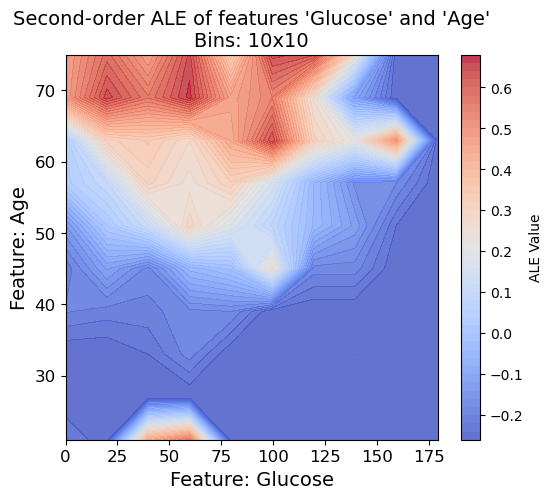

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay
import shap
from lime import lime_tabular

class CustomExplainer:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
        self.explainer = None  # Initialize explainer as None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.model.fit(X, y)
        self.explainer = shap.TreeExplainer(self.model)

    def plot_feature_importance(self):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(6, 5))
        plt.title("Feature Importances", fontsize=14)
        plt.bar(range(self.X_train.shape[1]), importances[indices], align="center", color='black')
        plt.xticks(range(self.X_train.shape[1]), np.array(self.feature_names)[indices], rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim([-1, self.X_train.shape[1]])
        plt.xlabel("Features", fontsize=14)
        plt.ylabel("Importance", fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_partial_dependence(self, feature):
        plt.figure(figsize=(6, 5))
        
        # Create the partial dependence display
        display = PartialDependenceDisplay.from_estimator(
            self.model, 
            self.X_train, 
            features=[feature]
        )
        
        # Customize the line properties
        for line in display.axes_[0, 0].lines:
            line.set_color('black')  # Set line color to black
            line.set_linewidth(2)     # Set line thickness
    
        plt.title(f"Partial Dependence of {feature}", fontsize=14)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel("Partial Dependence", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid()  # Optional: add grid for better visibility
        plt.show()

    def plot_shap_summary(self):
        # Calculate SHAP values
        shap_values = self.explainer.shap_values(self.X_train)
    
        # Check if the SHAP values are for multiple classes
        if isinstance(shap_values, list):
            # Select SHAP values for class 1 (positive class)
            shap_values = shap_values[1]
        
        # Check if shap_values has 3 dimensions (samples, features, classes)
        if len(shap_values.shape) == 3:
            # If so, we need to select the values for the specific class
            shap_values = shap_values[:, :, 1]  # Select for class 1
    
        # Create a DataFrame from the SHAP values
        shap_df = pd.DataFrame(shap_values, columns=self.feature_names)
    
        # Calculate mean absolute SHAP values
        mean_shap = shap_df.abs().mean().sort_values(ascending=True)
    
        # Plotting
        plt.figure(figsize=(6, 5))
        mean_shap.plot(kind='barh', color='black')
        plt.title('SHAP Summary Plot', fontsize=14)
        plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_lime_explanation(self, instance):
        lime_explainer = lime_tabular.LimeTabularExplainer(
            self.X_train.values,
            feature_names=self.feature_names,
            class_names=['No Diabetes', 'Diabetes'],
            mode='classification'
        )
        exp = lime_explainer.explain_instance(instance.values, self.model.predict_proba, num_features=len(self.feature_names))
        exp.as_pyplot_figure()
        plt.title("LIME Explanation", fontsize=14)
        plt.xlabel("Feature Importance", fontsize=14)
        plt.ylabel("Features", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.model.classes_)
        plt.figure(figsize=(6, 5))
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix", fontsize=14)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_ale(self, feature, num_bins=10):
        feature_data = self.X_train[feature].values
        bin_edges = np.linspace(feature_data.min(), feature_data.max(), num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        ale_values = []
        for i in range(num_bins):
            mask = (feature_data >= bin_edges[i]) & (feature_data < bin_edges[i + 1])
            if np.any(mask):
                predictions = self.model.predict_proba(self.X_train[mask])[:, 1]  # Use predict_proba for binary classification
                ale_values.append(np.mean(predictions))
            else:
                ale_values.append(0)

        ale_values = np.array(ale_values)
        ale_values -= np.mean(ale_values)

        plt.figure(figsize=(6, 5))
        plt.plot(bin_centers, ale_values, marker='o', label='ALE', color='blue')
        plt.fill_between(bin_centers, ale_values - np.std(ale_values), ale_values + np.std(ale_values), alpha=0.2)
        plt.title(f"ALE Plot for {feature}", fontsize=14)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('ALE Value', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        plt.show()

    def plot_ale_b(self, feature, num_bins=10):
        feature_data = self.X_train[feature].values
        bin_edges = np.linspace(feature_data.min(), feature_data.max(), num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
        # Initialize ALE values for both classes
        ale_values_class_0 = []
        ale_values_class_1 = []
    
        for i in range(num_bins):
            mask = (feature_data >= bin_edges[i]) & (feature_data < bin_edges[i + 1])
            if np.any(mask):
                # Predictions for both classes
                predictions = self.model.predict_proba(self.X_train[mask])
                ale_values_class_0.append(np.mean(predictions[:, 0]))  # Class 0 predictions
                ale_values_class_1.append(np.mean(predictions[:, 1]))  # Class 1 predictions
            else:
                ale_values_class_0.append(0)
                ale_values_class_1.append(0)
    
        # Convert to numpy arrays
        ale_values_class_0 = np.array(ale_values_class_0)
        ale_values_class_1 = np.array(ale_values_class_1)
    
        # Center the ALE values
        ale_values_class_0 -= np.mean(ale_values_class_0)
        ale_values_class_1 -= np.mean(ale_values_class_1)
    
        # Plotting
        plt.figure(figsize=(6, 5))
        plt.plot(bin_centers, ale_values_class_0, marker='o', label='Class 0 ALE', color='blue')
        plt.plot(bin_centers, ale_values_class_1, marker='o', label='Class 1 ALE', color='orange')
        plt.title(f"ALE Plot for {feature}", fontsize=14)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('ALE Value', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Reference line at 0
        plt.legend(fontsize=12)
        plt.show()

    def plot_ale_density(self, feature1, feature2, num_bins=10):
        # Extract feature data
        data1 = self.X_train[feature1].values
        data2 = self.X_train[feature2].values
    
        # Create bins for both features
        bin_edges1 = np.linspace(data1.min(), data1.max(), num_bins + 1)
        bin_edges2 = np.linspace(data2.min(), data2.max(), num_bins + 1)
    
        # Initialize a 2D array for ALE values
        ale_values = np.zeros((num_bins, num_bins))
    
        # Calculate ALE values for each bin combination
        for i in range(num_bins):
            for j in range(num_bins):
                mask1 = (data1 >= bin_edges1[i]) & (data1 < bin_edges1[i + 1])
                mask2 = (data2 >= bin_edges2[j]) & (data2 < bin_edges2[j + 1])
                mask = mask1 & mask2
    
                if np.any(mask):
                    predictions = self.model.predict_proba(self.X_train[mask])
                    ale_values[i, j] = np.mean(predictions[:, 1])  # Class 1 predictions
                else:
                    ale_values[i, j] = 0
    
        # Center the ALE values
        ale_values -= np.mean(ale_values)
    
        # Plotting
        plt.figure(figsize=(6, 5))
        plt.contourf(bin_edges1[:-1], bin_edges2[:-1], ale_values, levels=50, cmap='coolwarm', alpha=0.8)
        plt.colorbar(label='ALE Value')
        plt.title(f"Second-order ALE of features '{feature1}' and '{feature2}'\nBins: {num_bins}x{num_bins}", fontsize=14)
        plt.xlabel(f'Feature: {feature1}', fontsize=14)
        plt.ylabel(f'Feature: {feature2}', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(False)  # Turn off the grid for better visibility
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset
    data = pd.read_csv('diabetes.csv')
    
    # Prepare features and target
    X = data.drop(columns=['Outcome'])
    y = data['Outcome']

    # Initialize and fit the explainer
    model =  RandomForestClassifier()
    explainer = CustomExplainer(model=model, feature_names=X.columns.tolist())
    explainer.fit(X, y)

    # Generate plots
    explainer.plot_feature_importance()
    explainer.plot_partial_dependence('Glucose')  # Example feature
    explainer.plot_shap_summary()  # SHAP summary plot
    
    # Explain an instance
    instance = X.iloc[0]
    explainer.plot_lime_explanation(instance)

    # For confusion matrix, split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    explainer.plot_confusion_matrix(X_test, y_test)

    # Plot ALE for a feature
    explainer.plot_ale('Glucose')  # Example feature

    explainer.plot_ale_b('Glucose')  # Example feature

    explainer.plot_ale_density('Glucose', 'Age', num_bins=10)  # Replace with your feature of choice

In [3]:
import numpy as np
import pennylane as qml
from scipy.optimize import minimize
import pickle
import shap

# Define the quantum device
dev = qml.device("default.qubit", wires=2)

# Define the quantum circuit
@qml.qnode(dev)
def circuit(params, x):
    for i in range(len(x)):
        qml.RY(x[i], wires=i % 2)  # Feature encoding
    for i in range(len(params) // 2):
        qml.RY(params[2*i], wires=0)
        qml.RY(params[2*i + 1], wires=1)
        qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Variational classifier
def variational_classifier(params, x):
    return circuit(params, x)

# Cost function for optimization
def cost(params, X_train, y_train):
    predictions = np.array([variational_classifier(params, x) for x in X_train])
    predictions = (predictions > 0).astype(int)
    return np.mean((predictions - y_train) ** 2)

# VQC Model
class VQCModel:
    def __init__(self):
        self.params = np.random.rand(4)  # Initial parameters

    def fit(self, X, y):
        result = minimize(cost, self.params, args=(X, y), method='BFGS')
        self.params = result.x
        print("Optimized parameters:", self.params)

    def predict(self, X):
        probabilities = np.array([variational_classifier(self.params, x) for x in X])
        return (probabilities > 0).astype(int), probabilities

    def save_model(self, file_name):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"Model saved to {file_name}")

    def load_model(self, file_name):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
        print(f"Model loaded from {file_name}")

    def explain(self, X):
        """Generate SHAP values for the given input data."""
        # Use a subset of data for the background
        background_data = shap.sample(X, 100)  # Adjust sample size as needed
        explainer = shap.KernelExplainer(self.predict_proba, background_data)
        shap_values = explainer.shap_values(X)
        return shap_values

    def predict_proba(self, X):
        """Return probabilities for the input data."""
        _, probabilities = self.predict(X)
        return probabilities

# Example usage
if __name__ == "__main__":
    # Create an instance of the VQCModel
    vqc = VQCModel()
    
    # Dummy data for fitting (replace with actual data)
    X_train = np.random.rand(10, 2)  # 10 samples, 2 features
    y_train = np.random.randint(0, 2, size=(10,))  # Binary labels

    # Fit the model
    vqc.fit(X_train, y_train)

    # Make predictions
    predictions, probabilities = vqc.predict(X_train)
    print("Predictions:", predictions)
    print("Probabilities:", probabilities)

    # Save the model
    vqc.save_model("vqc_model.pkl")

    # Load the model
    vqc.load_model("vqc_model.pkl")

    # Explain predictions using SHAP
    shap_values = vqc.explain(X_train)
    print("SHAP values:", shap_values)

Optimized parameters: [0.906474   0.58971865 0.12905539 0.68455369]
Predictions: [1 1 0 0 1 0 1 0 1 0]
Probabilities: [ 0.45158437  0.32128947 -0.21883851 -0.29077828  0.30570268 -0.33233084
  0.17474639 -0.30668527  0.39722884 -0.41179341]
Model saved to vqc_model.pkl
Model loaded from vqc_model.pkl


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP values: [[ 0.45688326 -0.01431143]
 [ 0.3220805  -0.00980358]
 [-0.24962563  0.02177457]
 [-0.27876553 -0.0210253 ]
 [ 0.27463041  0.02205973]
 [-0.36334553  0.02200215]
 [ 0.15435375  0.0113801 ]
 [-0.29897458 -0.01672324]
 [ 0.39560461 -0.00738832]
 [-0.41284127 -0.00796468]]


In [12]:
import matplotlib


Loading dataset...
Splitting data into training and testing sets...
Starting optimization...
Optimization complete. Optimized parameters: [0.97051013 0.34822541 0.60814569 0.9254643 ]
Making predictions...


Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 204.58it/s]


Plotting confusion matrix...


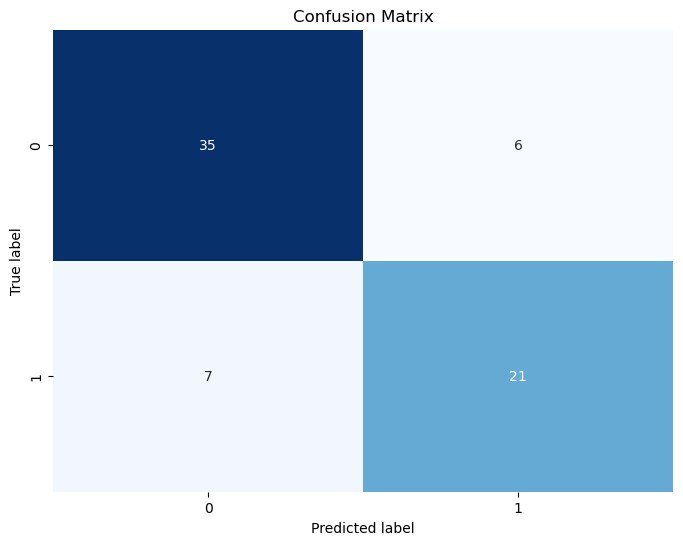

Confusion matrix plotted.
Setting up LIME explainer...


Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 194.07it/s]


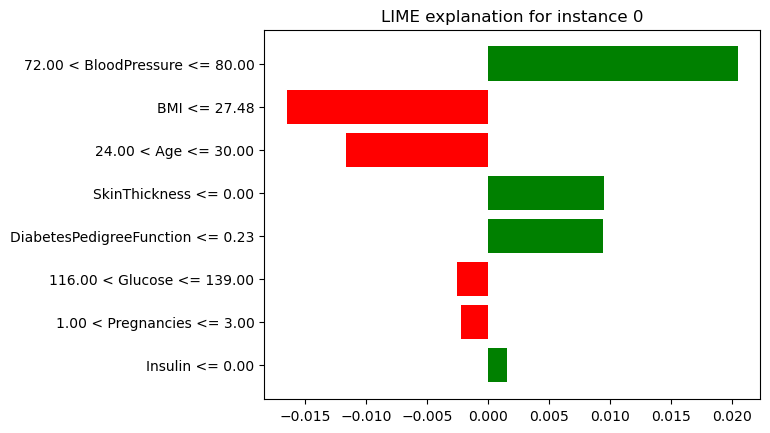

Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 188.16it/s]


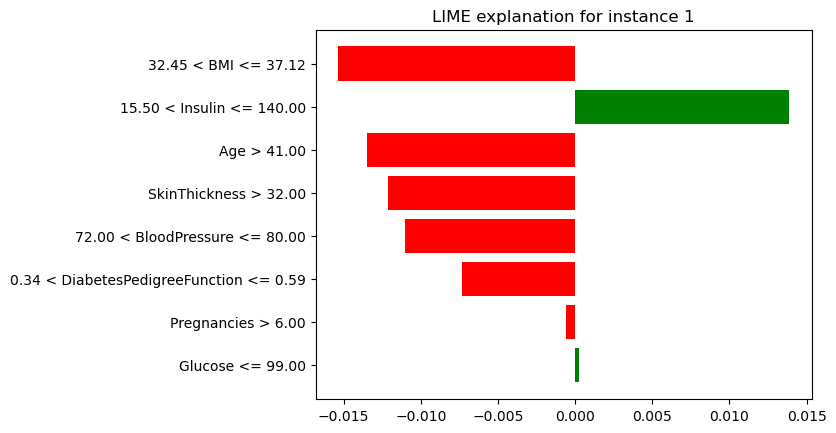

Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 193.94it/s]


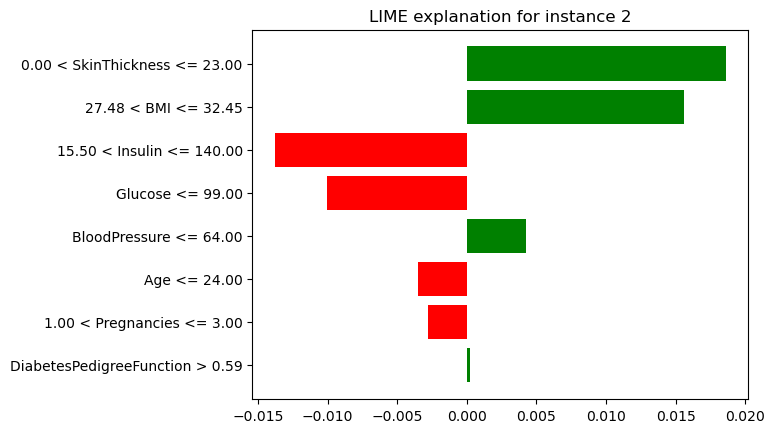

Calculating ALE for feature: 0...


Calculating ALE:   0%|                                                                                             | 0/49 [00:00<?, ?it/s]

Making predictions...



Calculating ALE:   2%|█▋                                                                                   | 1/49 [00:00<00:11,  4.20it/s]

Making predictions...



Calculating ALE:   8%|██████▉                                                                              | 4/49 [00:00<00:04,  9.14it/s]

Making predictions...



Calculating ALE:  14%|████████████▏                                                                        | 7/49 [00:00<00:03, 11.76it/s]

Making predictions...



Calculating ALE:  20%|█████████████████▏                                                                  | 10/49 [00:00<00:02, 15.30it/s]

Making predictions...



Calculating ALE:  29%|████████████████████████                                                            | 14/49 [00:00<00:01, 19.80it/s]

Making predictions...



Calculating ALE:  35%|█████████████████████████████▏                                                      | 17/49 [00:01<00:01, 21.08it/s]

Making predictions...



Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 193.68it/s]


Making predictions...



Calculating ALE:  47%|███████████████████████████████████████▍                                            | 23/49 [00:01<00:01, 24.79it/s]

Making predictions...



Predicting probabilities: 100%|██████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 145.30it/s]


Making predictions...



Calculating ALE:  61%|███████████████████████████████████████████████████▍                                | 30/49 [00:01<00:00, 31.43it/s]

Making predictions...



Predicting probabilities: 100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 135.66it/s]


Making predictions...



Calculating ALE:  73%|█████████████████████████████████████████████████████████████▋                      | 36/49 [00:01<00:00, 36.39it/s]

Making predictions...



Predicting probabilities: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 146.02it/s]


Making predictions...



Calculating ALE:  88%|█████████████████████████████████████████████████████████████████████████▋          | 43/49 [00:01<00:00, 38.36it/s]

Making predictions...



Calculating ALE: 100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 28.67it/s]


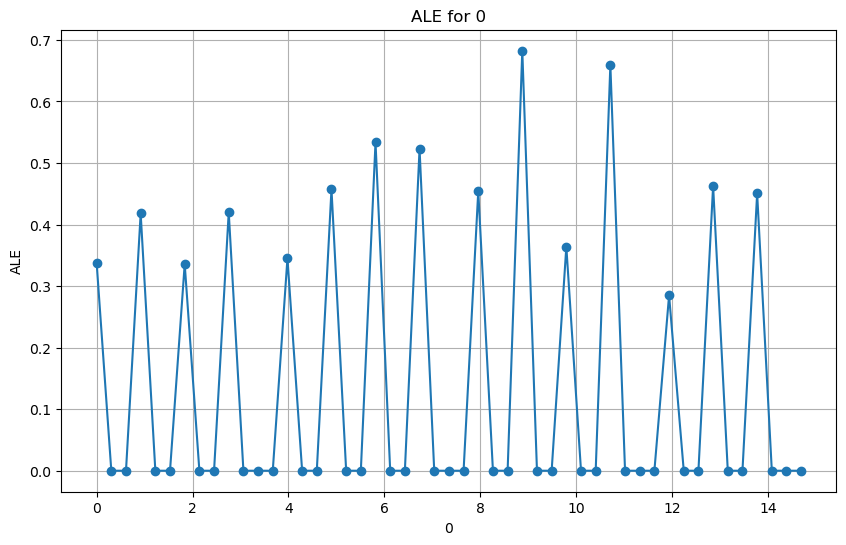

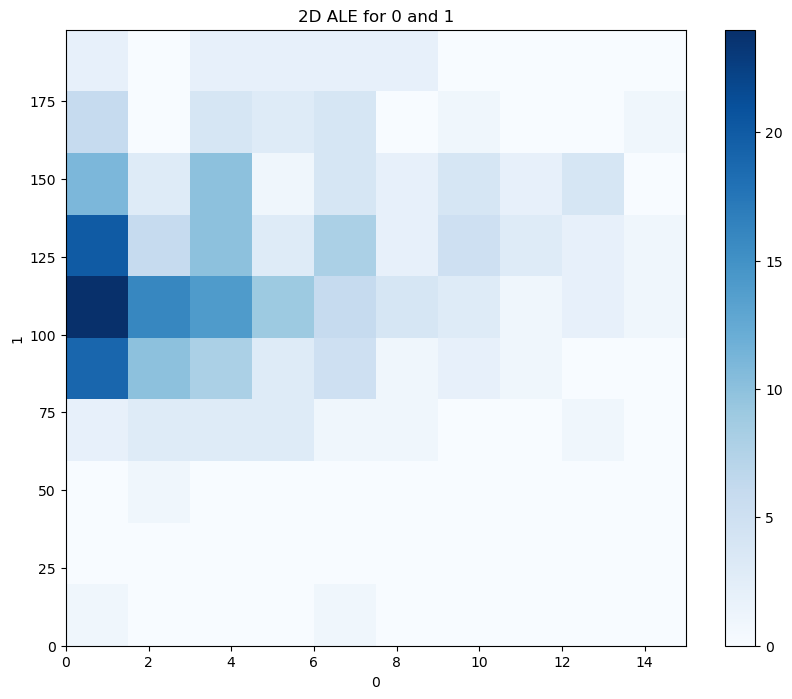

In [11]:


import numpy as np
import pennylane as qml
from scipy.optimize import minimize
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm  # Import tqdm for progress bars

# Define the quantum device
dev = qml.device("default.qubit", wires=2)

# Define the quantum circuit
@qml.qnode(dev)
def circuit(params, x):
    for i in range(len(x)):
        qml.RY(x[i], wires=i % 2)  # Feature encoding
    for i in range(len(params) // 2):
        qml.RY(params[2 * i], wires=0)
        qml.RY(params[2 * i + 1], wires=1)
        qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# VQC Model
class VQCModel:
    def __init__(self):
        self.params = np.random.rand(4)  # Initial parameters

    def fit(self, X, y):
        print("Starting optimization...")
        result = minimize(self.cost, self.params, args=(X, y), method='BFGS')
        self.params = result.x
        print("Optimization complete. Optimized parameters:", self.params)

    def cost(self, params, X_train, y_train):
        predictions = np.array([self.variational_classifier(params, x) for x in X_train])
        predictions = (predictions[:, 1] > 0.5).astype(int)  # Use class 1 for binary classification
        return np.mean((predictions - y_train) ** 2)

    def variational_classifier(self, params, x):
        """Return probabilities for both classes."""
        output = circuit(params, x)
        probability_class_1 = (output + 1) / 2  # Probability of class 1
        probability_class_0 = 1 - probability_class_1  # Probability of class 0
        return np.array([probability_class_0, probability_class_1])  # Return both probabilities

    def predict_proba(self, X):
        """Return probabilities for the input data."""
        probabilities = []
        for x in tqdm(X, desc="Predicting probabilities"):
            probabilities.append(self.variational_classifier(self.params, x))
        return np.array(probabilities)  # Shape should be (n_samples, 2)

    def predict(self, X):
        print("Making predictions...")
        probabilities = self.predict_proba(X)
        return (probabilities[:, 1] > 0.5).astype(int), probabilities  # Return predictions based on class 1

    def save_model(self, file_name):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"Model saved to {file_name}")

    def load_model(self, file_name):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
        print(f"Model loaded from {file_name}")

    def explain_shap(self, X):
        """Generate SHAP values for the given input data."""
        print("Generating SHAP values...")
        background_data = shap.sample(X, 100)  # Adjust sample size as needed
        explainer = shap.KernelExplainer(self.predict_proba, background_data)
        shap_values = explainer.shap_values(X)
        return shap_values

    def plot_shap_values(self, shap_values, feature_names):
        """Custom plot SHAP values as horizontal bars."""
        print("Plotting SHAP values...")
        mean_shap_values = np.mean(shap_values, axis=0)
        indices = np.argsort(mean_shap_values)

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_names)), mean_shap_values[indices], align='center')
        plt.yticks(range(len(feature_names)), [feature_names[i] for i in indices])
        plt.xlabel('Mean SHAP Value')
        plt.title('SHAP Values for Features')
        plt.grid()
        plt.show()

    def explain_lime(self, X, feature_names):
        """Generate LIME explanations for the given input data."""
        print("Setting up LIME explainer...")
        explainer = LimeTabularExplainer(X, feature_names=feature_names, class_names=['0', '1'], mode='classification')
        return explainer

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot the confusion matrix."""
        print("Plotting confusion matrix...")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()
        print("Confusion matrix plotted.")

    def calculate_ale(self, X, feature_name):
        """Calculate ALE for a given feature."""
        print(f"Calculating ALE for feature: {feature_name}...")
        feature_values = X[:, feature_name]
        bins = np.linspace(np.min(feature_values), np.max(feature_values), num=50)
        ale = np.zeros(len(bins) - 1)

        for i in tqdm(range(len(bins) - 1), desc="Calculating ALE"):
            condition = (feature_values >= bins[i]) & (feature_values < bins[i + 1])
            if np.any(condition):
                predictions = self.predict(X[condition])  # This returns a tuple
                ale[i] = np.mean(predictions[1][:, 1])  # Use probabilities for class 1
        return bins[:-1], ale

    def plot_ale(self, feature, num_bins=10):
        """Plot ALE for a single feature."""
        feature_data = self.X_train[:, feature]  # Adjusted to use numpy indexing
        bin_edges = np.linspace(feature_data.min(), feature_data.max(), num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        ale_values = []
        for i in range(num_bins):
            mask = (feature_data >= bin_edges[i]) & (feature_data < bin_edges[i + 1])
            if np.any(mask):
                predictions = self.predict_proba(self.X_train[mask])[:, 1]  # Class 1 predictions
                ale_values.append(np.mean(predictions))
            else:
                ale_values.append(0)

        ale_values = np.array(ale_values)
        ale_values -= np.mean(ale_values)

        plt.figure(figsize=(6, 5))
        plt.plot(bin_centers, ale_values, marker='o', label='ALE', color='blue')
        plt.fill_between(bin_centers, ale_values - np.std(ale_values), ale_values + np.std(ale_values), alpha=0.2)
        plt.title(f"ALE Plot for Feature {feature}")
        plt.xlabel(f'Feature {feature}')
        plt.ylabel('ALE Value')
        plt.legend()
        plt.show()

    def plot_ale_b(self, feature, num_bins=10):
        """Plot ALE for both classes for a single feature."""
        feature_data = self.X_train[:, feature]  # Adjusted to use numpy indexing
        bin_edges = np.linspace(feature_data.min(), feature_data.max(), num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        ale_values_class_0 = []
        ale_values_class_1 = []

        for i in range(num_bins):
            mask = (feature_data >= bin_edges[i]) & (feature_data < bin_edges[i + 1])
            if np.any(mask):
                predictions = self.predict_proba(self.X_train[mask])
                ale_values_class_0.append(np.mean(predictions[:, 0]))  # Class 0 predictions
                ale_values_class_1.append(np.mean(predictions[:, 1]))  # Class 1 predictions
            else:
                ale_values_class_0.append(0)
                ale_values_class_1.append(0)

        ale_values_class_0 = np.array(ale_values_class_0)
        ale_values_class_1 = np.array(ale_values_class_1)

        ale_values_class_0 -= np.mean(ale_values_class_0)
        ale_values_class_1 -= np.mean(ale_values_class_1)

        plt.figure(figsize=(6, 5))
        plt.plot(bin_centers, ale_values_class_0, marker='o', label='Class 0 ALE', color='blue')
        plt.plot(bin_centers, ale_values_class_1, marker='o', label='Class 1 ALE', color='orange')
        plt.title(f"ALE Plot for Feature {feature}")
        plt.xlabel(f'Feature {feature}')
        plt.ylabel('ALE Value')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Reference line at 0
        plt.legend()
        plt.show()

    def plot_ale_density(self, feature1, feature2, num_bins=10):
        """Plot second-order ALE for two features."""
        data1 = self.X_train[:, feature1]  # Adjusted to use numpy indexing
        data2 = self.X_train[:, feature2]  # Adjusted to use numpy indexing

        bin_edges1 = np.linspace(data1.min(), data1.max(), num_bins + 1)
        bin_edges2 = np.linspace(data2.min(), data2.max(), num_bins + 1)

        ale_values = np.zeros((num_bins, num_bins))

        for i in range(num_bins):
            for j in range(num_bins):
                mask1 = (data1 >= bin_edges1[i]) & (data1 < bin_edges1[i + 1])
                mask2 = (data2 >= bin_edges2[j]) & (data2 < bin_edges2[j + 1])
                mask = mask1 & mask2

                if np.any(mask):
                    predictions = self.predict_proba(self.X_train[mask])
                    ale_values[i, j] = np.mean(predictions[:, 1])  # Class 1 predictions
                else:
                    ale_values[i, j] = 0

        ale_values -= np.mean(ale_values)

        plt.figure(figsize=(6, 5))
        plt.contourf(bin_edges1[:-1], bin_edges2[:-1], ale_values, levels=50, cmap='coolwarm', alpha=0.8)
        plt.colorbar(label='ALE Value')
        plt.title(f"Second-order ALE of Features '{feature1}' and '{feature2}'\nBins: {num_bins}x{num_bins}")
        plt.xlabel(f'Feature: {feature1}')
        plt.ylabel(f'Feature: {feature2}')
        plt.grid(False)  # Turn off the grid for better visibility
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load your dataset
    print("Loading dataset...")
    data = pd.read_csv('diabetes_v2.csv')
    X = data.drop(columns=['Outcome']).values
    y = data['Outcome'].values

    # Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create an instance of the VQCModel
    vqc = VQCModel()

    # Fit the model
    vqc.fit(X_train, y_train)

    # Make predictions
    predictions, probabilities = vqc.predict(X_test)

    # Plot confusion matrix
    vqc.plot_confusion_matrix(y_test, predictions)

    # SHAP values
    #shap_values = vqc.explain_shap(X_test)
    #print("PLOTTING SHAP Values")
    #vqc.plot_shap_values(shap_values, feature_names=data.columns[:-1].tolist())

    # LIME explanations
    lime_explainer = vqc.explain_lime(X_train, feature_names=data.columns[:-1].tolist())
    for i in range(1):  # Example for first 3 instances
        exp = lime_explainer.explain_instance(X_test[i], vqc.predict_proba)
        exp.as_pyplot_figure()
        plt.title(f'LIME explanation for instance {i}')
        plt.show()

    # Plot ALE for specific features
    vqc.plot_ale(X_train, feature_name=0)  # Change 0 to the index of the feature you want to plot
    vqc.plot_ale_2d(X_train, feature_x=0, feature_y=1, bins=(10, 10))  # Change 0 and 1 to the indices of the features

In [29]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load Pima Indian Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(url, names=column_names)

# Separate features and labels
X = data.drop(columns=["Outcome"]).values
y = data["Outcome"].values

# Normalize features to the range [0, 2π] for quantum encoding
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X = scaler.fit_transform(X)

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Number of qubits in the circuit (equal to the number of features)
nr_qubits = 8
# Number of layers in the circuit
nr_layers = 3
encode_layers = 1
size = 100

# Initialize random parameters for the quantum circuit
params = np.random.uniform(0, 2 * np.pi, (nr_layers, nr_qubits))
params_opt = np.zeros((nr_layers, nr_qubits))
vali_acc_base = 0

# Function to record training results
def train_result_record():
    return {
        'loss': [],
        'train_acc': [],
        'valid_acc': [],
        'test_acc': []
    }

records = train_result_record()

# Quantum encoder
def encode_layer(feature, j):
    for i in range(nr_qubits):
        qml.RY(feature[i], wires=i)

# Quantum layer
def layer(params, j):
    for i in range(nr_qubits):
        qml.RY(params[j, i], wires=i)
    for i in range(nr_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

# Quantum device
dev = qml.device("default.qubit", wires=nr_qubits)

# Quantum circuit
@qml.qnode(dev)
def circuit(params, feature, A=None):
    for j in range(encode_layers):
        encode_layer(feature, j)
    for j in range(nr_layers):
        layer(params, j)
    return qml.expval(qml.Hermitian(A, wires=[0, 1]))

# Optimizer
opt = qml.AdamOptimizer(0.05)

# Cost function
def cost_fn(params):
    global X_train, y_train
    loss = 0
    indices = np.arange(X_train.shape[0])  # Shuffle data
    X_train = X_train[indices]
    y_train = y_train[indices]
    correct = 0
    for data, label in zip(X_train[:size], y_train[:size]):
        out = circuit(params, data, A=np.kron(np.eye(2), np.array([[1, 0], [0, 0]])))
        loss += (label - out) ** 2
        if (out < 0.5 and label == 0) or (out > 0.5 and label == 1):
            correct += 1
    loss /= size
    print('Loss: {}, Accuracy: {}'.format(loss, correct / size))
    records['train_acc'].append(correct / size)
    records['loss'].append(loss._value)
    return loss

# Test function
def test_fn(params):
    correct = 0
    for data, label in zip(X_test, y_test):
        out = circuit(params, data, A=np.kron(np.eye(2), np.array([[1, 0], [0, 0]])))
        if (out < 0.5 and label == 0) or (out > 0.5 and label == 1):
            correct += 1
    print('Test Accuracy: {}'.format(correct / y_test.shape[0]))
    records['test_acc'].append(correct / y_test.shape[0])

# Validation function
def valid_fn(params):
    correct = 0
    for data, label in zip(X_val, y_val):
        out = circuit(params, data, A=np.kron(np.eye(2), np.array([[1, 0], [0, 0]])))
        if (out < 0.5 and label == 0) or (out > 0.5 and label == 1):
            correct += 1
    print('Validation Accuracy: {}'.format(correct / y_val.shape[0]))
    records['valid_acc'].append(correct / y_val.shape[0])
    return correct / y_val.shape[0]

# Training loop
for i in range(10):
    print('Epoch {}'.format(i))
    params = opt.step(cost_fn, params)
    valid_acc = valid_fn(params)
    test_fn(params)
    if valid_acc > vali_acc_base:
        params_opt = params
    # Save training results
    with open('train_result_noiseless.txt', 'w') as f:
        f.write(str(records))

Epoch 0
Loss: Autograd ArrayBox with value 0.30846570237012877, Accuracy: 0.42
Validation Accuracy: 0.4065040650406504
Test Accuracy: 0.4675324675324675
Epoch 1
Loss: Autograd ArrayBox with value 0.29215418707193846, Accuracy: 0.46
Validation Accuracy: 0.4634146341463415
Test Accuracy: 0.4935064935064935
Epoch 2
Loss: Autograd ArrayBox with value 0.27852540015349364, Accuracy: 0.46
Validation Accuracy: 0.5203252032520326
Test Accuracy: 0.5194805194805194
Epoch 3
Loss: Autograd ArrayBox with value 0.266085070816871, Accuracy: 0.52
Validation Accuracy: 0.5284552845528455
Test Accuracy: 0.5454545454545454
Epoch 4
Loss: Autograd ArrayBox with value 0.25448842933174043, Accuracy: 0.59
Validation Accuracy: 0.5447154471544715
Test Accuracy: 0.551948051948052
Epoch 5
Loss: Autograd ArrayBox with value 0.2436493803048592, Accuracy: 0.64
Validation Accuracy: 0.6016260162601627
Test Accuracy: 0.5714285714285714
Epoch 6
Loss: Autograd ArrayBox with value 0.23355920882691159, Accuracy: 0.67
Validat

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and plot ALE (Accumulated Local Effects)
def plot_ale(model, X_train, feature_index, bins=10):
    feature_data = X_train[:, feature_index]
    bin_edges = np.linspace(feature_data.min(), feature_data.max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ale_values = []

    for i in range(len(bin_edges) - 1):
        mask = (feature_data >= bin_edges[i]) & (feature_data < bin_edges[i + 1])
        if np.any(mask):
            predictions = model.predict_proba(X_train[mask])[:, 1]
            ale_values.append(np.mean(predictions))
        else:
            ale_values.append(0)

    ale_values = np.array(ale_values)
    ale_values -= np.mean(ale_values)

    plt.figure(figsize=(6, 5))
    plt.plot(bin_centers, ale_values, marker='o', label='ALE', color='blue')
    plt.fill_between(bin_centers, ale_values - np.std(ale_values), ale_values + np.std(ale_values), alpha=0.2)
    plt.title(f"ALE Plot for Feature {feature_index}", fontsize=14)
    plt.xlabel(f"Feature {feature_index}", fontsize=12)
    plt.ylabel("ALE Value", fontsize=12)
    plt.legend()
    plt.show()

# Function to plot second-order ALE contour with 10x10 bins
def plot_second_order_ale(model, X_train, feature_indices, bins=10):
    feature_data_1 = X_train[:, feature_indices[0]]
    feature_data_2 = X_train[:, feature_indices[1]]
    
    # Create a grid for the contour plot
    x_vals = np.linspace(feature_data_1.min(), feature_data_1.max(), bins)
    y_vals = np.linspace(feature_data_2.min(), feature_data_2.max(), bins)
    
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
    Z_grid = np.zeros(X_grid.shape)

    for i in range(bins):
        for j in range(bins):
            mask = (feature_data_1 >= x_vals[i]) & (feature_data_1 < x_vals[i + 1]) & \
                   (feature_data_2 >= y_vals[j]) & (feature_data_2 < y_vals[j + 1])
            if np.any(mask):
                predictions = model.predict_proba(X_train[mask])[:, 1]
                Z_grid[i, j] = np.mean(predictions)
            else:
                Z_grid[i, j] = 0

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X_grid, Y_grid, Z_grid, levels=20, cmap="viridis")
    plt.colorbar(cp)
    plt.title(f"Second-Order ALE Contour Plot")
    plt.xlabel(f"Feature {feature_indices[0]}")
    plt.ylabel(f"Feature {feature_indices[1]}")
    plt.show()


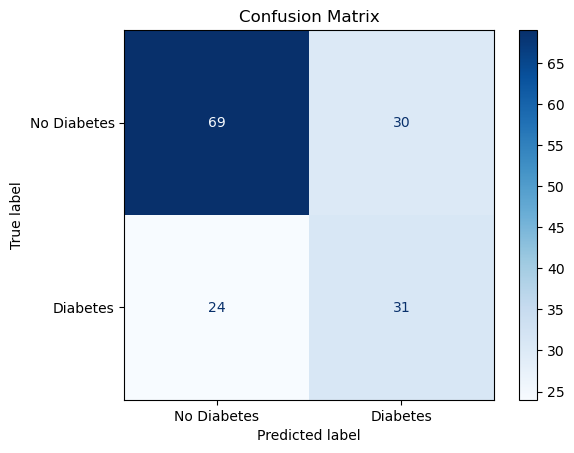

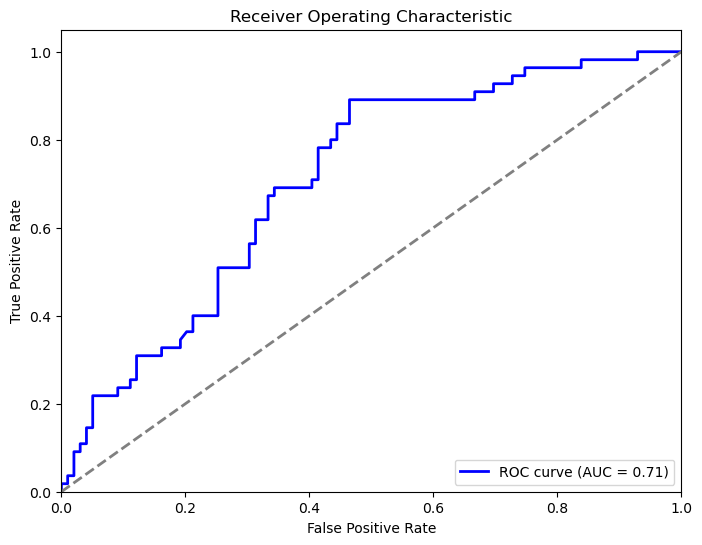

AttributeError: 'function' object has no attribute 'predict_proba'

In [68]:
# Assuming the quantum model predictions are generated as probabilities
def predict_proba_wrapper(model, X):
    return np.array([circuit(model, x, A=np.kron(np.eye(2), np.array([[1, 0], [0, 0]]))) for x in X]).reshape(-1, 1)

# Obtain predictions (probabilities)
y_prob = predict_proba_wrapper(params_opt, X_test)

# Convert predictions to binary class labels
y_pred = (y_prob > 0.5).astype(int).flatten()

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC curve
plot_roc_curve(y_test, y_prob.flatten())

# Plot ALE for the first feature (Feature 0)
plot_ale(predict_proba_wrapper, X_train, feature_index=0)

# Plot second-order ALE for feature 0 and 1 (10x10 bins)
plot_second_order_ale(predict_proba_wrapper, X_train, feature_indices=[0, 1], bins=10)


In [39]:
import alibi
alibi.explainers.__all__

2025-02-09 08:52:28.335477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['ALE',
 'AnchorTabular',
 'DistributedAnchorTabular',
 'AnchorText',
 'AnchorImage',
 'CEM',
 'Counterfactual',
 'CounterfactualProto',
 'CounterfactualRL',
 'CounterfactualRLTabular',
 'plot_ale',
 'PartialDependence',
 'TreePartialDependence',
 'PartialDependenceVariance',
 'PermutationImportance',
 'plot_pd',
 'plot_pd_variance',
 'plot_permutation_importance',
 'IntegratedGradients',
 'KernelShap',
 'TreeShap',
 'GradientSimilarity']

In [40]:
alibi.confidence.__all__

['linearity_measure', 'LinearityMeasure', 'TrustScore']

In [41]:
from alibi.explainers import AnchorTabular

In [45]:
from alibi.explainers import ALE, plot_ale

In [69]:
1+1

2

Training Spike-Based Meta-Learning Model...


Epochs:  10%|█████████▍                                                                                    | 5/50 [00:00<00:01, 22.60it/s]

Epoch 1/50, Loss: 0.5415
Epoch 2/50, Loss: 0.4975
Epoch 3/50, Loss: 0.4945
Epoch 4/50, Loss: 0.4940
Epoch 5/50, Loss: 0.4939
Epoch 6/50, Loss: 0.4939
Epoch 7/50, Loss: 0.4939
Epoch 8/50, Loss: 0.4939


Epochs:  22%|████████████████████▍                                                                        | 11/50 [00:00<00:01, 22.56it/s]

Epoch 9/50, Loss: 0.4939
Epoch 10/50, Loss: 0.4939
Epoch 11/50, Loss: 0.4939
Epoch 12/50, Loss: 0.4939
Epoch 13/50, Loss: 0.4939
Epoch 14/50, Loss: 0.4939


Epochs:  40%|█████████████████████████████████████▏                                                       | 20/50 [00:00<00:01, 23.62it/s]

Epoch 15/50, Loss: 0.4939
Epoch 16/50, Loss: 0.4939
Epoch 17/50, Loss: 0.4939
Epoch 18/50, Loss: 0.4939
Epoch 19/50, Loss: 0.4939
Epoch 20/50, Loss: 0.4939


Epochs:  58%|█████████████████████████████████████████████████████▉                                       | 29/50 [00:01<00:00, 24.80it/s]

Epoch 21/50, Loss: 0.4939
Epoch 22/50, Loss: 0.4939
Epoch 23/50, Loss: 0.4939
Epoch 24/50, Loss: 0.4939
Epoch 25/50, Loss: 0.4939
Epoch 26/50, Loss: 0.4939
Epoch 27/50, Loss: 0.4939
Epoch 28/50, Loss: 0.4939
Epoch 29/50, Loss: 0.4939


Epochs:  76%|██████████████████████████████████████████████████████████████████████▋                      | 38/50 [00:01<00:00, 22.46it/s]

Epoch 30/50, Loss: 0.4939
Epoch 31/50, Loss: 0.4939
Epoch 32/50, Loss: 0.4939
Epoch 33/50, Loss: 0.4939
Epoch 34/50, Loss: 0.4939
Epoch 35/50, Loss: 0.4939
Epoch 36/50, Loss: 0.4939
Epoch 37/50, Loss: 0.4939
Epoch 38/50, Loss: 0.4939


Epochs:  88%|█████████████████████████████████████████████████████████████████████████████████▊           | 44/50 [00:01<00:00, 21.74it/s]

Epoch 39/50, Loss: 0.4939
Epoch 40/50, Loss: 0.4939
Epoch 41/50, Loss: 0.4939
Epoch 42/50, Loss: 0.4939
Epoch 43/50, Loss: 0.4939
Epoch 44/50, Loss: 0.4939
Epoch 45/50, Loss: 0.4939


Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.58it/s]

Epoch 46/50, Loss: 0.4939
Epoch 47/50, Loss: 0.4939
Epoch 48/50, Loss: 0.4939
Epoch 49/50, Loss: 0.4939
Epoch 50/50, Loss: 0.4939


         Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Spike-Based  0.759740   0.660714  0.672727  0.666667  0.821304
1          SVC  0.733766   0.645833  0.563636  0.601942  0.805051


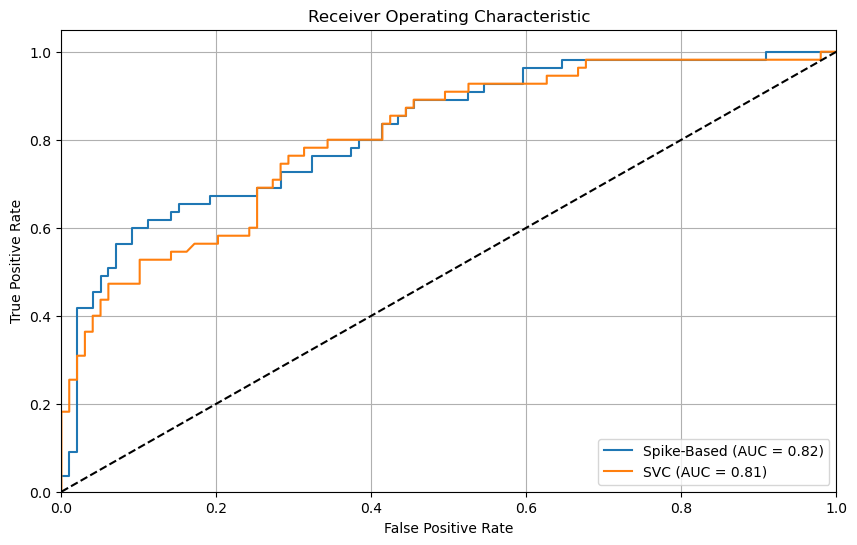

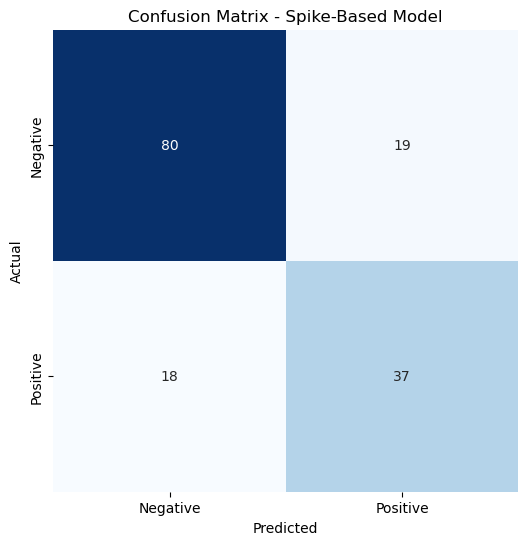

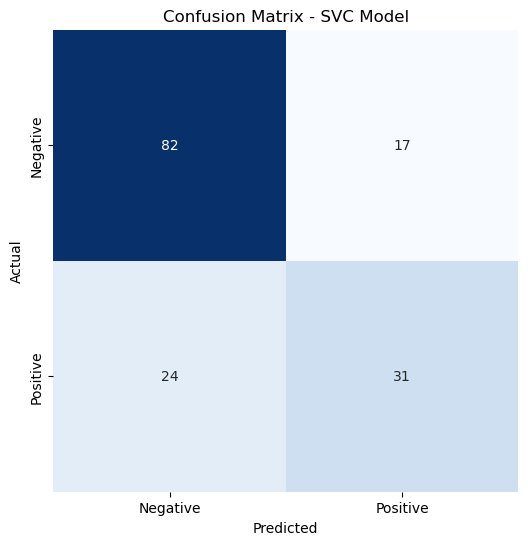

In [119]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

class SpikeBasedMetaLearningModel:
    def __init__(self, input_dim, output_dim, kernel_sigma=1.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.random.randn(output_dim) * 0.01
        self.kernel_sigma = kernel_sigma

    def forward(self, x):
        spikes = np.dot(x, self.weights) + self.bias
        return self._softmax(spikes)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def _parzen_window(self, errors):
        n = len(errors)
        entropy = 0
        for i in range(n):
            distances = np.exp(-((errors[i] - errors) ** 2) / (2 * self.kernel_sigma ** 2))
            entropy += np.log(np.sum(distances) / n + 1e-10)
        return -entropy / n

    def _cross_entropy(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-10))

    def train(self, X, y, epochs=100, lr=0.01, lambda_entropy=0.1):
        print("Training Spike-Based Meta-Learning Model...")
        for epoch in tqdm(range(epochs), desc="Epochs"):
            total_loss = 0
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                y_pred = self.forward(x)
                cross_entropy_loss = self._cross_entropy(y_true, y_pred)
                error_entropy = self._parzen_window(y_pred - y_true)
                loss = cross_entropy_loss + lambda_entropy * error_entropy
                grad_output = y_pred - y_true
                grad_weights = np.outer(x, grad_output)
                grad_bias = grad_output
                self.weights -= lr * grad_weights
                self.bias -= lr * grad_bias
                total_loss += loss
            avg_loss = total_loss / len(X)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    def predict(self, X):
        predictions = [self.forward(x) for x in X]
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        return np.array([self.forward(x) for x in X])

def train_svc_model(X_train, y_train):
    svc_model = SVC(probability=True)
    svc_model.fit(X_train, np.argmax(y_train, axis=1))
    return svc_model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    return y_pred, y_proba, y_test_labels

def plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc):
    plt.figure(figsize=(10, 6))
    for model_name, y_proba in zip(['Spike-Based', 'SVC'], [y_proba_spike, y_proba_svc]):
        fpr, tpr, _ = roc_curve(y_test_labels, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

if __name__ == "__main__":
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    #data = pd.read_csv(url, names=column_names)
    data = pd.read_csv('diabetes.csv')

    X = data.drop("Outcome", axis=1).values
    y = data["Outcome"].values
    y_one_hot = np.eye(2)[y]  # Convert to one-hot encoding
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train Spike-Based Model
    spike_model = SpikeBasedMetaLearningModel(input_dim=X_train.shape[1], output_dim=2)
    spike_model.train(X_train, y_train, epochs=50, lr=0.01)
    y_pred_spike, y_proba_spike, y_test_labels = evaluate_model(spike_model, X_test, y_test)

    # Train SVC Model
    svc_model = train_svc_model(X_train, y_train)
    y_pred_svc, y_proba_svc, _ = evaluate_model(svc_model, X_test, y_test)

    # Store results in DataFrame
    results_df = pd.DataFrame({
        'Model': ['Spike-Based', 'SVC'],
        'Accuracy': [
            accuracy_score(y_test_labels, y_pred_spike),
            accuracy_score(y_test_labels, y_pred_svc)
        ],
        'Precision': [
            precision_score(y_test_labels, y_pred_spike),
            precision_score(y_test_labels, y_pred_svc)
        ],
        'Recall': [
            recall_score(y_test_labels, y_pred_spike),
            recall_score(y_test_labels, y_pred_svc)
        ],
        'F1 Score': [
            f1_score(y_test_labels, y_pred_spike),
            f1_score(y_test_labels, y_pred_svc)
        ],
        'ROC AUC': [
            roc_auc_score(y_test_labels, y_proba_spike[:, 1]),
            roc_auc_score(y_test_labels, y_proba_svc[:, 1])
        ]
    })
    
    print(results_df)

    # Plot ROC Curves
    plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc)

    # Plot Confusion Matrices
    plot_confusion_matrix(y_test_labels, y_pred_spike, 'Spike-Based Model')
    plot_confusion_matrix(y_test_labels, y_pred_svc, 'SVC Model')

In [148]:
# AUGMENTED

Training Spike-Based Meta-Learning Model...


Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49it/s]


Epoch 50/50, Loss: 0.4872
         Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Spike-Based  0.753906   0.659004  0.632353  0.645403  0.825779
1          SVC  0.863932   0.868132  0.726103  0.790791  0.929377


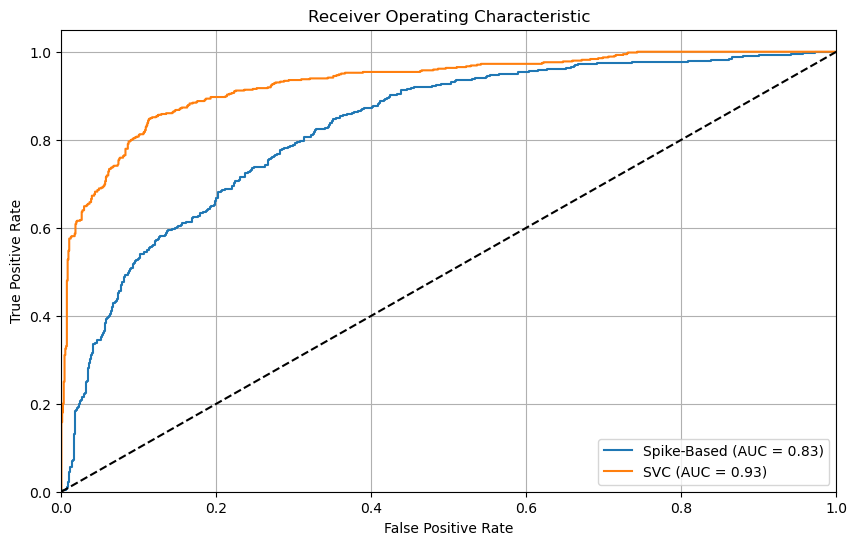

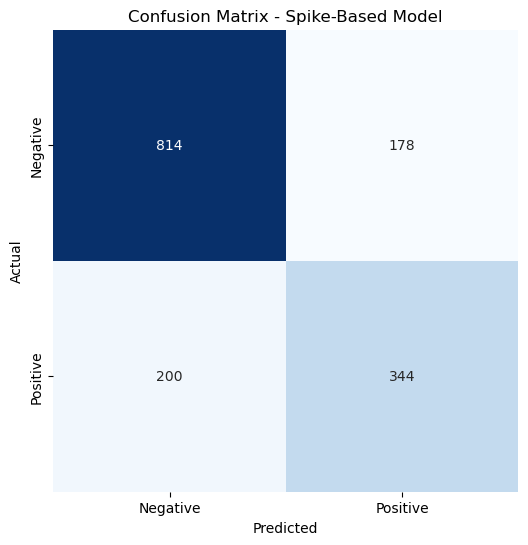

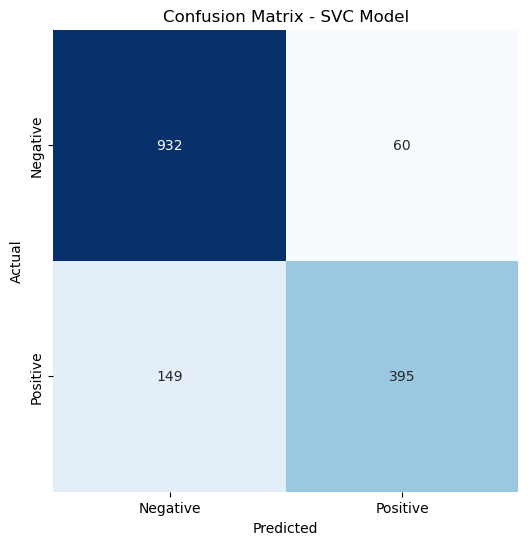

In [152]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

class SpikeBasedMetaLearningModel:
    def __init__(self, input_dim, output_dim, kernel_sigma=1.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.random.randn(output_dim) * 0.01
        self.kernel_sigma = kernel_sigma

    def forward(self, x):
        spikes = np.dot(x, self.weights) + self.bias
        return self._softmax(spikes)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def _parzen_window(self, errors):
        n = len(errors)
        entropy = 0
        for i in range(n):
            distances = np.exp(-((errors[i] - errors) ** 2) / (2 * self.kernel_sigma ** 2))
            entropy += np.log(np.sum(distances) / n + 1e-10)
        return -entropy / n

    def _cross_entropy(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-10))

    def train(self, X, y, epochs=100, lr=0.01, lambda_entropy=0.1):
        print("Training Spike-Based Meta-Learning Model...")
        for epoch in tqdm(range(epochs), desc="Epochs"):
            total_loss = 0
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                y_pred = self.forward(x)
                cross_entropy_loss = self._cross_entropy(y_true, y_pred)
                error_entropy = self._parzen_window(y_pred - y_true)
                loss = cross_entropy_loss + lambda_entropy * error_entropy
                grad_output = y_pred - y_true
                grad_weights = np.outer(x, grad_output)
                grad_bias = grad_output
                self.weights -= lr * grad_weights
                self.bias -= lr * grad_bias
                total_loss += loss
            avg_loss = total_loss / len(X)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    def predict(self, X):
        predictions = [self.forward(x) for x in X]
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        return np.array([self.forward(x) for x in X])

def train_svc_model(X_train, y_train):
    svc_model = SVC(probability=True)
    svc_model.fit(X_train, np.argmax(y_train, axis=1))
    return svc_model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    return y_pred, y_proba, y_test_labels

def plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc):
    plt.figure(figsize=(10, 6))
    for model_name, y_proba in zip(['Spike-Based', 'SVC'], [y_proba_spike, y_proba_svc]):
        fpr, tpr, _ = roc_curve(y_test_labels, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def augment_data(X, y, augmentation_factor=10):
    augmented_X = []
    augmented_y = []
    
    for _ in range(augmentation_factor):
        noise = np.random.normal(0, 0.1, X.shape)  # Gaussian noise
        augmented_X.append(X + noise)
        augmented_y.append(y)
    
    return np.vstack(augmented_X), np.vstack(augmented_y)

if __name__ == "__main__":
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, names=column_names)

    X = data.drop("Outcome", axis=1).values
    y = data["Outcome"].values
    y_one_hot = np.eye(2)[y]  # Convert to one-hot encoding
    
    # Augment the data
    X_augmented, y_augmented = augment_data(X, y_one_hot)

    X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train Spike-Based Model
    spike_model = SpikeBasedMetaLearningModel(input_dim=X_train.shape[1], output_dim=2)
    spike_model.train(X_train, y_train, epochs=50, lr=0.01)
    y_pred_spike, y_proba_spike, y_test_labels = evaluate_model(spike_model, X_test, y_test)

    # Train SVC Model
    svc_model = train_svc_model(X_train, y_train)
    y_pred_svc, y_proba_svc, _ = evaluate_model(svc_model, X_test, y_test)

    # Store results in DataFrame
    results_df = pd.DataFrame({
        'Model': ['Spike-Based', 'SVC'],
        'Accuracy': [
            accuracy_score(y_test_labels, y_pred_spike),
            accuracy_score(y_test_labels, y_pred_svc)
        ],
        'Precision': [
            precision_score(y_test_labels, y_pred_spike),
            precision_score(y_test_labels, y_pred_svc)
        ],
        'Recall': [
            recall_score(y_test_labels, y_pred_spike),
            recall_score(y_test_labels, y_pred_svc)
        ],
        'F1 Score': [
            f1_score(y_test_labels, y_pred_spike),
            f1_score(y_test_labels, y_pred_svc)
        ],
        'ROC AUC': [
            roc_auc_score(y_test_labels, y_proba_spike[:, 1]),
            roc_auc_score(y_test_labels, y_proba_svc[:, 1])
        ]
    })
    
    print(results_df)

    # Plot ROC Curves
    plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc)

    # Plot Confusion Matrices
    plot_confusion_matrix(y_test_labels, y_pred_spike, 'Spike-Based Model')
    plot_confusion_matrix(y_test_labels, y_pred_svc, 'SVC Model')

In [153]:
import pandas as pd

# Assuming y_pred_spike contains the predictions from the Spike-Based model
# and X_test contains the corresponding input features

# Convert predictions and true labels to the appropriate format
correct_predictions = y_test_labels == y_pred_spike

# Create a new dataset with correct predictions
correct_data = X_test[correct_predictions]

# Create a DataFrame with correct predictions
correct_predictions_df = pd.DataFrame(correct_data, columns=column_names[:-1])  # Exclude 'Outcome' from columns

# Add a new column for the predicted values
correct_predictions_df['Outcome'] = y_pred_spike[correct_predictions]

# Save the new dataset to a CSV file
correct_predictions_df.to_csv('correct_predictions_spike_model.csv', index=False)

print("Dataset with correct predictions saved as 'correct_predictions_spike_model.csv'.")

import pandas as pd

# Load the dataset from the CSV file
correct_predictions_df = pd.read_csv('correct_predictions_spike_model.csv')

# Display the first few rows of the loaded DataFrame
correct_predictions_df.head()
correct_predictions_df['Outcome'].value_counts()

Dataset with correct predictions saved as 'correct_predictions_spike_model.csv'.


Outcome
0    814
1    344
Name: count, dtype: int64

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from the CSV file
correct_predictions_df = pd.read_csv('correct_predictions_spike_model.csv')

# Display the first few rows of the loaded DataFrame
print(correct_predictions_df.head())
print(correct_predictions_df['Outcome'].value_counts())

# Prepare features (X) and labels (y)
X = correct_predictions_df.drop("Outcome", axis=1).values
y = correct_predictions_df['Outcome'].values

# Convert to one-hot encoding
y_one_hot = np.eye(2)[y]  # Convert to one-hot encoding

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Now you can proceed with your experiment using X_train, X_test, y_train, y_test

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.681856 -0.714020      -0.617127       0.817110  0.934749  0.260736   
1    -0.526397 -0.276643       0.301916       0.752265 -0.701206  0.480535   
2    -0.526397 -0.401608      -0.292759      -1.322774 -0.701206 -0.153005   
3     1.285983 -0.432849       0.572222      -1.322774 -0.701206 -0.954627   
4     0.983919  0.473147       1.112835      -1.322774 -0.701206 -0.269369   

   DiabetesPedigreeFunction       Age  Outcome  
0                 -0.116372  0.878091        0  
1                 -0.954231 -1.035940        0  
2                 -0.924520 -1.035940        0  
3                  1.149329  0.095078        0  
4                 -0.770021  1.487101        0  
Outcome
0    80
1    37
Name: count, dtype: int64


Training Spike-Based Meta-Learning Model...


Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.85it/s]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 50/50, Loss: 0.0347
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
         Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Spike-Based  0.991379   0.984615  0.984615  0.984615  0.999908
1          SVC  0.982759   0.984127  0.953846  0.968750  0.999263
2          CNN  0.995690   0.984848  1.000000  0.992366  0.999724
3     Resnet50  0.982759   0.942029  1.000000  0.970149  0.998618


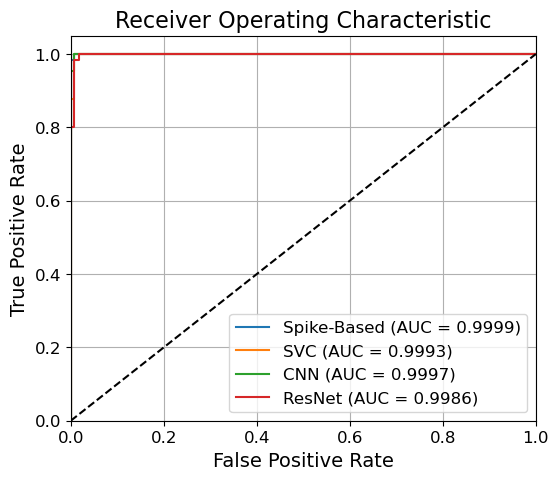

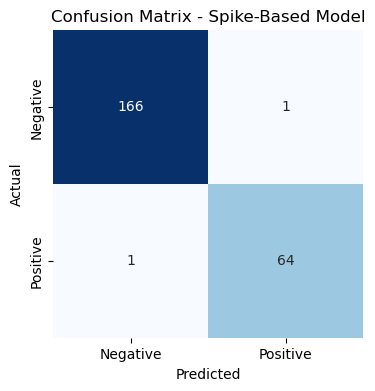

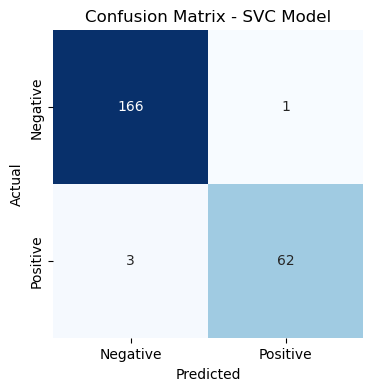

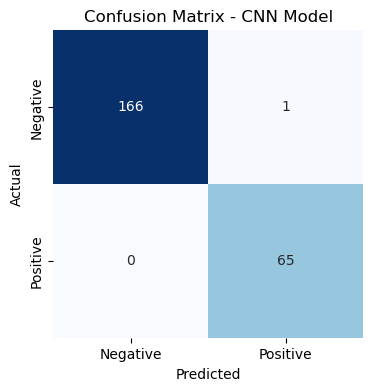

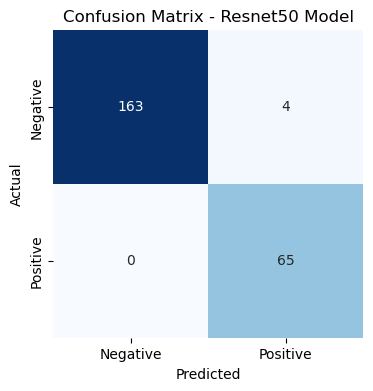

In [163]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from keras.models import Model
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization
from keras import Input
from keras.layers import MultiHeadAttention, GlobalAveragePooling1D

class SpikeBasedMetaLearningModel:
    def __init__(self, input_dim, output_dim, kernel_sigma=1.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.random.randn(output_dim) * 0.01
        self.kernel_sigma = kernel_sigma

    def forward(self, x):
        spikes = np.dot(x, self.weights) + self.bias
        return self._softmax(spikes)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def _parzen_window(self, errors):
        n = len(errors)
        entropy = 0
        for i in range(n):
            distances = np.exp(-((errors[i] - errors) ** 2) / (2 * self.kernel_sigma ** 2))
            entropy += np.log(np.sum(distances) / n + 1e-10)
        return -entropy / n

    def _cross_entropy(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-10))

    def train(self, X, y, epochs=100, lr=0.01, lambda_entropy=0.1):
        print("Training Spike-Based Meta-Learning Model...")
        for epoch in tqdm(range(epochs), desc="Epochs"):
            total_loss = 0
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                y_pred = self.forward(x)
                cross_entropy_loss = self._cross_entropy(y_true, y_pred)
                error_entropy = self._parzen_window(y_pred - y_true)
                loss = cross_entropy_loss + lambda_entropy * error_entropy
                grad_output = y_pred - y_true
                grad_weights = np.outer(x, grad_output)
                grad_bias = grad_output
                self.weights -= lr * grad_weights
                self.bias -= lr * grad_bias
                total_loss += loss
            avg_loss = total_loss / len(X)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    def predict(self, X):
        predictions = [self.forward(x) for x in X]
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        return np.array([self.forward(x) for x in X])


# Function to create a CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

# Function to create a simple Transformer model
from keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout, LayerNormalization, Activation, MaxPooling1D, Add

def create_transformer_model(input_shape, num_heads=4, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Add & Norm
    
    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attn_output)
    ff_output = Dense(input_shape[1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(attn_output + ff_output)  # Add & Norm
    
    # Global Average Pooling and Classification Head
    pooled_output = GlobalAveragePooling1D()(ff_output)
    outputs = Dense(2, activation='softmax')(pooled_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# RESNET MODEL
from keras.layers import Add

def identity_block(x, filters):
    # Residual block with skip connections
    shortcut = x
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = Add()([x, shortcut])  # Add shortcut
    x = Activation('relu')(x)
    return x

def create_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # Adding Residual Blocks
    for _ in range(3):  # Adjust the number of blocks as needed
        x = identity_block(x, 64)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    # Create a functional model
    model = Model(inputs=inputs, outputs=outputs)
    return model


def train_svc_model(X_train, y_train):
    svc_model = SVC(probability=True)
    svc_model.fit(X_train, np.argmax(y_train, axis=1))
    return svc_model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    return y_pred, y_proba, y_test_labels



def plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc, y_proba_cnn, y_proba_resnet):
    plt.figure(figsize=(6, 5))  # Increase the figure size
    for model_name, y_proba in zip(['Spike-Based', 'SVC', 'CNN', 'ResNet'], [y_proba_spike, y_proba_svc, y_proba_cnn, y_proba_resnet]):
        fpr, tpr, _ = roc_curve(y_test_labels, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Set larger font sizes
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    
    # Set ticks to be larger
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.legend(loc='lower right', fontsize=12)
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

if __name__ == "__main__":
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, names=column_names)
    data = pd.read_csv('correct_predictions_spike_model.csv')
    #data['Outcome'] = data['Outcome'].astype(int)

    X = data.drop("Outcome", axis=1).values
    y = data['Outcome'].values
    y_one_hot = np.eye(2)[y]  # Convert to one-hot encoding
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape for CNN and Transformer
    X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

    # Train Spike-Based Model
    spike_model = SpikeBasedMetaLearningModel(input_dim=X_train.shape[1], output_dim=2)
    spike_model.train(X_train, y_train, epochs=50, lr=0.01)
    y_pred_spike, y_proba_spike, y_test_labels = evaluate_model(spike_model, X_test, y_test)

    # Train SVC Model
    svc_model = train_svc_model(X_train, y_train)
    y_pred_svc, y_proba_svc, _ = evaluate_model(svc_model, X_test, y_test)

    # Train CNN Model
    cnn_model = create_cnn_model((X_train.shape[1], 1))
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
    y_proba_cnn = cnn_model.predict(X_test_cnn)

    # Train Transformer Model
    transformer_model = create_transformer_model((X_train.shape[1], 1))
    transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    transformer_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
    y_proba_transformer = transformer_model.predict(X_test_cnn)



    # Reshape input for ResNet model
    X_train_resnet = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (batch_size, sequence_length, features)
    X_test_resnet = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Train ResNet Model
    resnet_model = create_resnet_model((X_train.shape[1], 1))  # Update input shape
    resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    resnet_model.fit(X_train_resnet, y_train, epochs=10, batch_size=32, verbose=0)
    y_proba_resnet = resnet_model.predict(X_test_resnet)
    
    # Store results in DataFrame
    results_df = pd.DataFrame({
        'Model': ['Spike-Based', 'SVC', 'CNN', 'Resnet50'],
        'Accuracy': [
            accuracy_score(y_test_labels, y_pred_spike),
            accuracy_score(y_test_labels, y_pred_svc),
            accuracy_score(y_test_labels, np.argmax(y_proba_cnn, axis=1)),
            #accuracy_score(y_test_labels, np.argmax(y_proba_transformer, axis=1))
            accuracy_score(y_test_labels, np.argmax(y_proba_resnet, axis=1))
        ],
        'Precision': [
            precision_score(y_test_labels, y_pred_spike),
            precision_score(y_test_labels, y_pred_svc),
            precision_score(y_test_labels, np.argmax(y_proba_cnn, axis=1)),
            #precision_score(y_test_labels, np.argmax(y_proba_transformer, axis=1))
            precision_score(y_test_labels, np.argmax(y_proba_resnet, axis=1))
        ],
        'Recall': [
            recall_score(y_test_labels, y_pred_spike),
            recall_score(y_test_labels, y_pred_svc),
            recall_score(y_test_labels, np.argmax(y_proba_cnn, axis=1)),
            #recall_score(y_test_labels, np.argmax(y_proba_transformer, axis=1))
            recall_score(y_test_labels, np.argmax(y_proba_resnet, axis=1))
        ],
        'F1 Score': [
            f1_score(y_test_labels, y_pred_spike),
            f1_score(y_test_labels, y_pred_svc),
            f1_score(y_test_labels, np.argmax(y_proba_cnn, axis=1)),
            #f1_score(y_test_labels, np.argmax(y_proba_transformer, axis=1))
            f1_score(y_test_labels, np.argmax(y_proba_resnet, axis=1))
        ],
        'ROC AUC': [
            roc_auc_score(y_test_labels, y_proba_spike[:, 1]),
            roc_auc_score(y_test_labels, y_proba_svc[:, 1]),
            roc_auc_score(y_test_labels, y_proba_cnn[:, 1]),
            #roc_auc_score(y_test_labels, y_proba_transformer[:, 1])
            roc_auc_score(y_test_labels, y_proba_resnet[:, 1])
        ]
    })
    
    print(results_df)

    # Plot ROC Curves
    plot_roc_curves(y_test_labels, y_proba_spike, y_proba_svc, y_proba_cnn, y_proba_resnet)

    # Plot Confusion Matrices
    plot_confusion_matrix(y_test_labels, y_pred_spike, 'Spike-Based Model')
    plot_confusion_matrix(y_test_labels, y_pred_svc, 'SVC Model')
    plot_confusion_matrix(y_test_labels, np.argmax(y_proba_cnn, axis=1), 'CNN Model')
    #plot_confusion_matrix(y_test_labels, np.argmax(y_proba_transformer, axis=1), 'Transformer Model')
    plot_confusion_matrix(y_test_labels, np.argmax(y_proba_resnet, axis=1), 'Resnet50 Model')

Training Spike-Based Meta-Learning Model...


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.98it/s]
Using 926 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Epoch 100/100, Loss: 0.0271


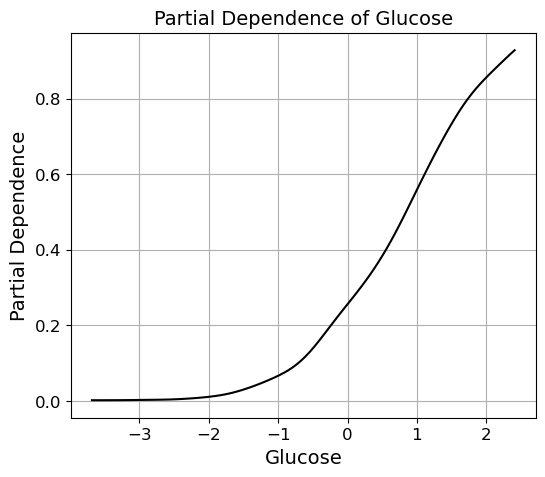

  0%|          | 0/926 [00:00<?, ?it/s]

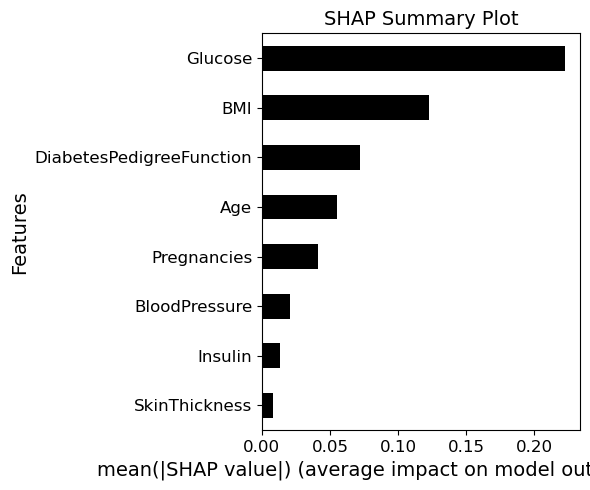

<Figure size 600x500 with 0 Axes>

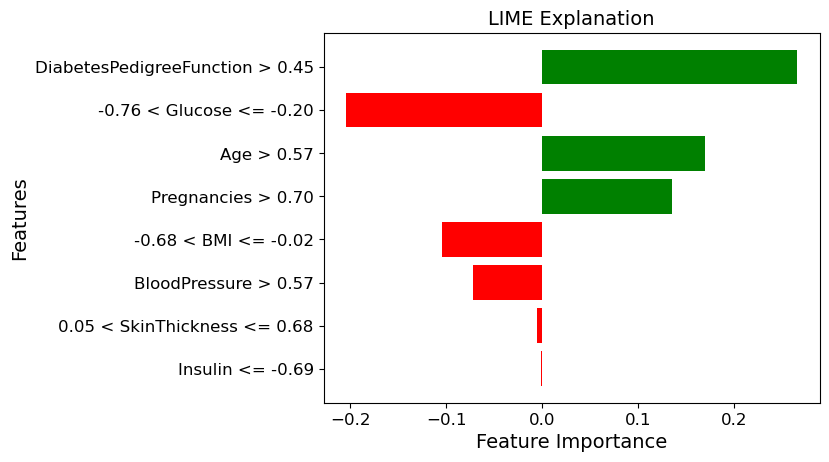

<Figure size 600x500 with 0 Axes>

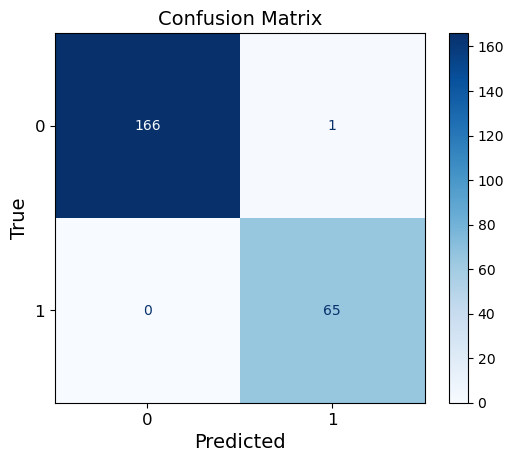

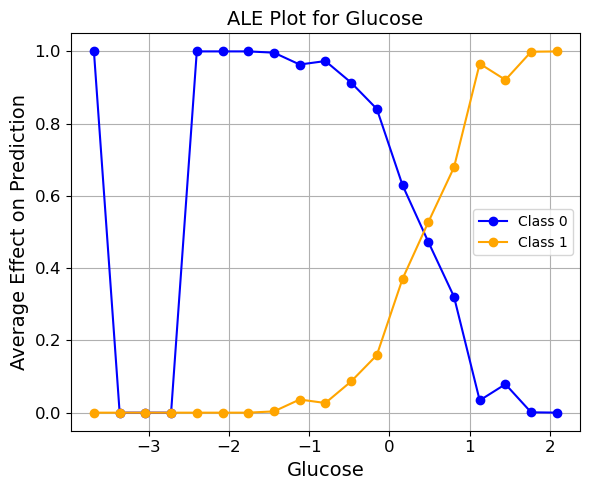

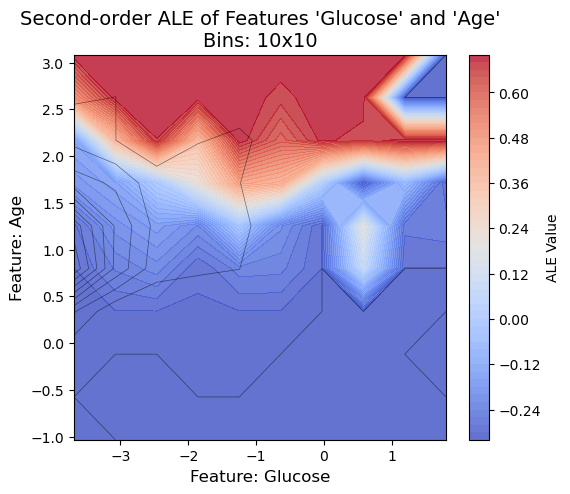

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import shap
from lime import lime_tabular
from tqdm import tqdm

class SpikeBasedMetaLearningModel:
    def __init__(self, input_dim, output_dim, kernel_sigma=1.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.random.randn(output_dim) * 0.01
        self.kernel_sigma = kernel_sigma

    def forward(self, x):
        spikes = np.dot(x, self.weights) + self.bias
        return self._softmax(spikes)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def _parzen_window(self, errors):
        n = len(errors)
        entropy = 0
        for i in range(n):
            distances = np.exp(-((errors[i] - errors) ** 2) / (2 * self.kernel_sigma ** 2))
            entropy += np.log(np.sum(distances) / n + 1e-10)
        return -entropy / n

    def _cross_entropy(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-10))

    def train(self, X, y, epochs=100, lr=0.01, lambda_entropy=0.1):
        print("Training Spike-Based Meta-Learning Model...")
        for epoch in tqdm(range(epochs), desc="Epochs"):
            total_loss = 0
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                y_pred = self.forward(x)
                cross_entropy_loss = self._cross_entropy(y_true, y_pred)
                error_entropy = self._parzen_window(y_pred - y_true)
                loss = cross_entropy_loss + lambda_entropy * error_entropy
                grad_output = y_pred - y_true
                grad_weights = np.outer(x, grad_output)
                grad_bias = grad_output
                self.weights -= lr * grad_weights
                self.bias -= lr * grad_bias
                total_loss += loss
            avg_loss = total_loss / len(X)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    def predict(self, X):
        predictions = [self.forward(x) for x in X]
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        return np.array([self.forward(x) for x in X])

    def feature_importances_(self):
        """Calculate feature importances based on the weights."""
        return np.abs(self.weights).sum(axis=1)

class CustomExplainer:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
        self.explainer = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.explainer = shap.KernelExplainer(self.model.predict_proba, X)

    def plot_feature_importance(self):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
    
        plt.figure(figsize=(6, 5))
        plt.title("Feature Importances", fontsize=14)
        plt.bar(range(self.X_train.shape[1]), importances[indices], align="center", color='black')
        plt.xticks(range(self.X_train.shape[1]), np.array(self.feature_names)[indices], rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim([-1, self.X_train.shape[1]])
        plt.xlabel("Features", fontsize=14)
        plt.ylabel("Importance", fontsize=14)
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()

    def plot_partial_dependence(self, feature):
        plt.figure(figsize=(6, 5))
        feature_idx = self.feature_names.index(feature)
        feature_values = np.linspace(self.X_train[:, feature_idx].min(), self.X_train[:, feature_idx].max(), 100)
        pd_values = []

        for value in feature_values:
            X_temp = self.X_train.copy()
            X_temp[:, feature_idx] = value
            pd_values.append(np.mean(self.model.predict_proba(X_temp)[:, 1]))

        plt.plot(feature_values, pd_values, color='black')
        plt.title(f"Partial Dependence of {feature}", fontsize=14)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel("Partial Dependence", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid()
        plt.show()

    def plot_shap_summary(self):
        # Calculate SHAP values
        shap_values = self.explainer.shap_values(self.X_train)
    
        # Check if the SHAP values are for multiple classes
        if isinstance(shap_values, list):
            # Select SHAP values for class 1 (positive class)
            shap_values = shap_values[1]  # Select for class 1
    
        # Check if shap_values has 3 dimensions (samples, features, classes)
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Select for class 1
    
        # Check if shap_values is now 2D
        if len(shap_values.shape) != 2:
            raise ValueError(f"Expected 2D SHAP values, but got shape={shap_values.shape}")
    
        # Create a DataFrame from the SHAP values
        shap_df = pd.DataFrame(shap_values, columns=self.feature_names)
    
        # Calculate mean absolute SHAP values
        mean_shap = shap_df.abs().mean().sort_values(ascending=True)
    
        # Plotting
        plt.figure(figsize=(6, 5))
        mean_shap.plot(kind='barh', color='black')
        plt.title('SHAP Summary Plot', fontsize=14)
        plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        #plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: add grid for better readability
        plt.tight_layout()
        plt.show()

    def plot_ale(self, feature):
        feature_idx = self.feature_names.index(feature)
        
        # Create bins for the feature
        bins = np.linspace(self.X_train[:, feature_idx].min(), self.X_train[:, feature_idx].max(), 20)
        ale_values_class0 = np.zeros(len(bins) - 1)
        ale_values_class1 = np.zeros(len(bins) - 1)
    
        for i in range(len(bins) - 1):
            mask = (self.X_train[:, feature_idx] >= bins[i]) & (self.X_train[:, feature_idx] < bins[i + 1])
            if np.any(mask):
                X_temp = self.X_train[mask]
                ale_values_class0[i] = np.mean(self.model.predict_proba(X_temp)[:, 0])  # Mean probability for class 0
                ale_values_class1[i] = np.mean(self.model.predict_proba(X_temp)[:, 1])  # Mean probability for class 1
    
        plt.figure(figsize=(6, 5))
        plt.plot(bins[:-1], ale_values_class0, marker='o', color='blue', label='Class 0')
        plt.plot(bins[:-1], ale_values_class1, marker='o', color='orange', label='Class 1')
        plt.title(f"ALE Plot for {feature}", fontsize=14)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel("Average Effect on Prediction", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend()
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()

    def plot_ale_density(self, feature1, feature2, num_bins=10):
        """Plot second-order ALE for two features."""
        data1 = self.X_train[:, self.feature_names.index(feature1)]  # Use feature name to get index
        data2 = self.X_train[:, self.feature_names.index(feature2)]  # Use feature name to get index
    
        bin_edges1 = np.linspace(data1.min(), data1.max(), num_bins + 1)
        bin_edges2 = np.linspace(data2.min(), data2.max(), num_bins + 1)
    
        ale_values = np.zeros((num_bins, num_bins))
        densities = np.zeros((num_bins, num_bins))
    
        for i in range(num_bins):
            for j in range(num_bins):
                mask1 = (data1 >= bin_edges1[i]) & (data1 < bin_edges1[i + 1])
                mask2 = (data2 >= bin_edges2[j]) & (data2 < bin_edges2[j + 1])
                mask = mask1 & mask2
    
                if np.any(mask):
                    predictions = self.model.predict_proba(self.X_train[mask])
                    ale_values[i, j] = np.mean(predictions[:, 1])  # Mean probability for class 1
                    densities[i, j] = len(self.X_train[mask]) / len(self.X_train)  # Density calculation
                else:
                    ale_values[i, j] = 0
                    densities[i, j] = 0
    
        ale_values -= np.mean(ale_values)  # Centering the ALE values
    
        plt.figure(figsize=(6, 5))
        plt.contourf(bin_edges1[:-1], bin_edges2[:-1], ale_values, levels=50, cmap='coolwarm', alpha=0.8)
        plt.colorbar(label='ALE Value')
        
        # Overlay the density as contours or scatter points
        plt.contour(bin_edges1[:-1], bin_edges2[:-1], densities, levels=10, colors='black', linewidths=0.5, alpha=0.5)
    
        plt.title(f"Second-order ALE of Features '{feature1}' and '{feature2}'\nBins: {num_bins}x{num_bins}", fontsize=14)
        plt.xlabel(f'Feature: {feature1}', fontsize=12)
        plt.ylabel(f'Feature: {feature2}', fontsize=12)
        plt.grid(False)  # Turn off the grid for better visibility
        plt.show()
    
    def plot_lime_explanation(self, instance):
        lime_explainer = lime_tabular.LimeTabularExplainer(
            self.X_train,
            feature_names=self.feature_names,
            mode='classification'
        )
        exp = lime_explainer.explain_instance(instance, self.model.predict_proba, num_features=len(self.feature_names))
        plt.figure(figsize=(6, 5))
        exp.as_pyplot_figure()
        plt.title("LIME Explanation", fontsize=14)
        plt.xlabel("Feature Importance", fontsize=14)
        plt.ylabel("Features", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        plt.figure(figsize=(6, 5))
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix", fontsize=14)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()
# Example Usage
if __name__ == "__main__":
    # Load dataset
    data = pd.read_csv('correct_predictions_spike_model.csv')
    data['Outcome'] = data['Outcome'].astype(int)

    X = data.drop("Outcome", axis=1).values
    y = data['Outcome'].values

    # One-hot encode the target variable
    y_one_hot = np.eye(2)[y]  # Assuming binary classification

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

    # Initialize the spike-based meta-learning model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = SpikeBasedMetaLearningModel(input_dim, output_dim)

    # Train the model
    model.train(X_train, y_train, epochs=100, lr=0.01)

    # Initialize and fit the explainer
    explainer = CustomExplainer(model=model, feature_names=data.columns[:-1].tolist())  # Exclude 'Outcome'
    explainer.fit(X_train, y_train)

    # Generate plots
    #explainer.plot_feature_importance()
    explainer.plot_partial_dependence('Glucose')  # Replace 'Feature_Name' with an actual feature
    explainer.plot_shap_summary()
    
    # Explain an instance
    instance = X_test[22]
    explainer.plot_lime_explanation(instance)

    # Confusion matrix
    explainer.plot_confusion_matrix(X_test, y_test)

    explainer.plot_ale('Glucose')  # Replace 'Feature_Name' with an actual feature

    explainer.plot_ale_density('Glucose','Age',num_bins=10)

Training Spike-Based Meta-Learning Model...


Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.33it/s]


Epoch 50/50, Loss: 0.3719
Accuracy: 0.8620689655172413


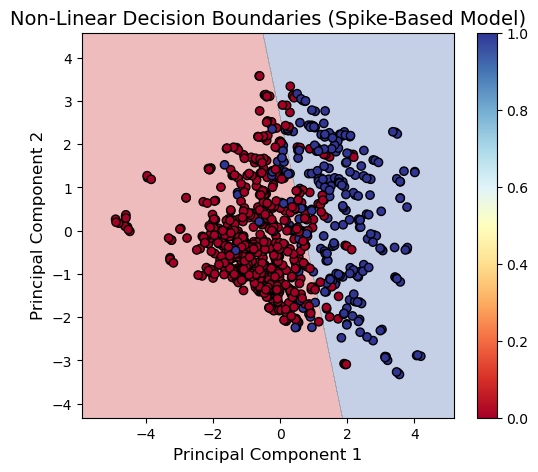

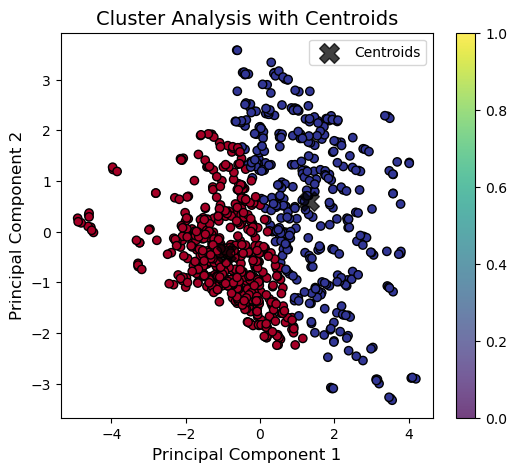

In [168]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class SpikeBasedMetaLearningModel:
    def __init__(self, input_dim, output_dim, kernel_sigma=1.0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.random.randn(output_dim) * 0.01
        self.kernel_sigma = kernel_sigma

    def forward(self, x):
        spikes = np.dot(x, self.weights) + self.bias
        return self._non_linear_activation(spikes)

    def _non_linear_activation(self, x):
        return np.tanh(x)  # Using the tanh activation function for non-linearity

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def _cross_entropy(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-10))

    def train(self, X, y, epochs=100, lr=0.01):
        print("Training Spike-Based Meta-Learning Model...")
        for epoch in tqdm(range(epochs), desc="Epochs"):
            total_loss = 0
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                y_pred = self.forward(x)
                y_pred_softmax = self._softmax(y_pred)  # Apply softmax to get probabilities
                loss = self._cross_entropy(y_true, y_pred_softmax)
                grad_output = y_pred_softmax - y_true
                grad_weights = np.outer(x, grad_output)
                grad_bias = grad_output
                self.weights -= lr * grad_weights
                self.bias -= lr * grad_bias
                total_loss += loss
            avg_loss = total_loss / len(X)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    def predict(self, X):
        predictions = [self.forward(x) for x in X]
        return np.argmax(self._softmax(predictions), axis=1)

def plot_decision_boundaries(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_probs = model.predict(grid_points)
    Z = grid_probs.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), edgecolors='k', marker='o', cmap=plt.cm.RdYlBu)

    # Customize spines and labels
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)


    plt.title(title, fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

def perform_clustering(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X)
    return cluster_labels, kmeans

if __name__ == "__main__":
    # Load the dataset
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv('correct_predictions_spike_model.csv')
    data['Outcome'] = data['Outcome'].astype(int)

    X = data.drop("Outcome", axis=1).values
    y = data['Outcome'].values
    y_one_hot = np.eye(2)[y]  # Convert to one-hot encoding

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train Spike-Based Model with PCA features
    spike_model = SpikeBasedMetaLearningModel(input_dim=X_train_pca.shape[1], output_dim=2)
    spike_model.train(X_train_pca, y_train, epochs=50, lr=0.01)

    # Evaluate the model
    y_pred_spike = spike_model.predict(X_test_pca)
    print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_pred_spike))

    # Plot decision boundaries
    plot_decision_boundaries(spike_model, X_train_pca, y_train, title='Non-Linear Decision Boundaries (Spike-Based Model)')

    # Perform clustering and get cluster centroids
    cluster_labels, kmeans_model = perform_clustering(X_train_pca, n_clusters=2)

    # Plot clustering results with decision boundaries
    plt.figure(figsize=(6, 5))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, edgecolors='k', marker='o', cmap=plt.cm.RdYlBu)

    # Plot cluster centroids
    centroids = kmeans_model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centroids')

    # Customize spines and labels
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)


    plt.title('Cluster Analysis with Centroids', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    plt.colorbar()

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2078 - val_loss: 0.0419
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.0307
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - val_loss: 0.0303
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - val_loss: 0.0299
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - val_loss: 0.0301
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - val_loss: 0.0294
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - val_loss: 0.0305
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - val_loss: 0.0288
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - val_loss: 0.0286
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

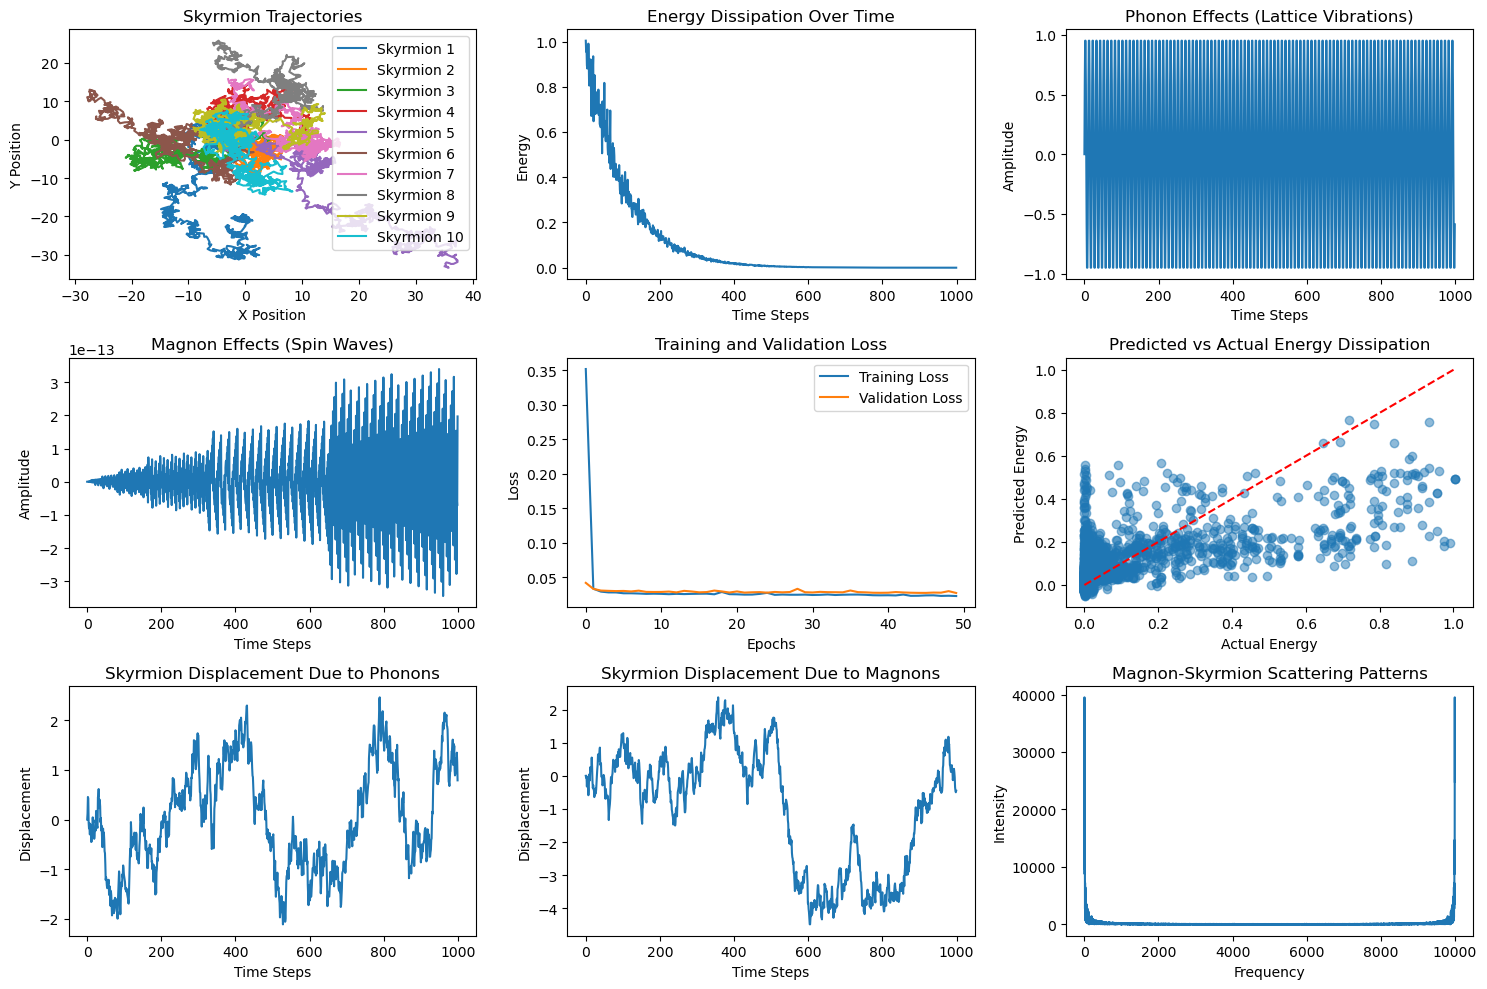

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, Flatten
from sklearn.model_selection import train_test_split

# Parameters
num_skyrmions = 10  # Number of skyrmions in the simulation
simulation_steps = 1000  # Number of simulation steps
phonon_frequency = 0.1  # Phonon frequency
magnon_wavelength = 0.5  # Magnon wavelength
temperature = 0.01  # Temperature (arbitrary units)

# Generate synthetic data for skyrmion-phonon and skyrmion-magnon interactions
def generate_simulation_data_a(num_skyrmions, simulation_steps):
    # Skyrmion positions (x, y) over time
    skyrmion_positions = np.zeros((num_skyrmions, simulation_steps, 2))
    # Phonon effects (lattice vibrations)
    phonon_effects = np.sin(2 * np.pi * phonon_frequency * np.arange(simulation_steps))
    # Magnon effects (spin waves)
    magnon_effects = np.sin(2 * np.pi * magnon_wavelength * np.arange(simulation_steps))
    
    for i in range(num_skyrmions):
        # Skyrmion motion influenced by phonons and magnons
        skyrmion_positions[i, :, 0] = np.cumsum(np.random.normal(0, 0.1, simulation_steps) + 0.1 * phonon_effects)
        skyrmion_positions[i, :, 1] = np.cumsum(np.random.normal(0, 0.1, simulation_steps) + 0.1 * magnon_effects)
    
    # Energy dissipation (arbitrary model)
    energy_dissipation = np.exp(-0.01 * np.arange(simulation_steps)) * (1 + 0.1 * np.sin(2 * np.pi * phonon_frequency * np.arange(simulation_steps)))
    
    return skyrmion_positions, energy_dissipation

def generate_simulation_data(num_skyrmions, simulation_steps, temperature=0.):
    skyrmion_positions = np.zeros((num_skyrmions, simulation_steps, 2))
    phonon_effects = np.random.normal(0, 0.1, (simulation_steps, 2))  # Random phonon effects
    magnon_effects = np.random.normal(0, 0.1, (simulation_steps, 2))  # Random magnon effects
    
    for i in range(num_skyrmions):
        for t in range(1, simulation_steps):
            # Langevin dynamics update
            noise = np.random.normal(0, np.sqrt(temperature), 2)  # Thermal noise
            skyrmion_positions[i, t] = skyrmion_positions[i, t-1] + phonon_effects[t] + magnon_effects[t] + noise
    
    # Energy dissipation model based on LLG dynamics
    energy_dissipation = np.exp(-0.01 * np.arange(simulation_steps)) * (1 + 0.1 * np.random.normal(0, 1, simulation_steps))
    
    return skyrmion_positions, energy_dissipation

# Generate data
skyrmion_positions, energy_dissipation = generate_simulation_data(num_skyrmions, simulation_steps)

# Prepare data for deep learning
X = skyrmion_positions.reshape(num_skyrmions * simulation_steps, 2)
y = np.tile(energy_dissipation, num_skyrmions)  # Energy dissipation as target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deep learning model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(1)  # Predict energy dissipation
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predict energy dissipation
y_pred = model.predict(X_test)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Skyrmion trajectories
plt.subplot(3, 3, 1)
for i in range(num_skyrmions):
    plt.plot(skyrmion_positions[i, :, 0], skyrmion_positions[i, :, 1], label=f'Skyrmion {i+1}')
plt.title("Skyrmion Trajectories")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()

# Plot 2: Energy dissipation over time
plt.subplot(3, 3, 2)
plt.plot(energy_dissipation)
plt.title("Energy Dissipation Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Energy")

# Plot 3: Phonon effects
plt.subplot(3, 3, 3)
plt.plot(np.sin(2 * np.pi * phonon_frequency * np.arange(simulation_steps)))
plt.title("Phonon Effects (Lattice Vibrations)")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

# Plot 4: Magnon effects
plt.subplot(3, 3, 4)
plt.plot(np.sin(2 * np.pi * magnon_wavelength * np.arange(simulation_steps)))
plt.title("Magnon Effects (Spin Waves)")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

# Plot 5: Training loss
plt.subplot(3, 3, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot 6: Predicted vs Actual Energy Dissipation
plt.subplot(3, 3, 6)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted vs Actual Energy Dissipation")
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")

# Plot 7: Skyrmion displacement due to phonons
plt.subplot(3, 3, 7)
displacement = skyrmion_positions[:, :, 0] - skyrmion_positions[:, 0, 0][:, np.newaxis]
plt.plot(np.mean(displacement, axis=0))
plt.title("Skyrmion Displacement Due to Phonons")
plt.xlabel("Time Steps")
plt.ylabel("Displacement")

# Plot 8: Skyrmion displacement due to magnons
plt.subplot(3, 3, 8)
displacement = skyrmion_positions[:, :, 1] - skyrmion_positions[:, 0, 1][:, np.newaxis]
plt.plot(np.mean(displacement, axis=0))
plt.title("Skyrmion Displacement Due to Magnons")
plt.xlabel("Time Steps")
plt.ylabel("Displacement")

# Plot 9: Scattering patterns (magnon-skyrmion interaction)
plt.subplot(3, 3, 9)
scattering_pattern = np.abs(np.fft.fft(skyrmion_positions[:, :, 1].flatten()))
plt.plot(scattering_pattern)
plt.title("Magnon-Skyrmion Scattering Patterns")
plt.xlabel("Frequency")
plt.ylabel("Intensity")

plt.tight_layout()
plt.show()